# sci_ATAC embryo atlas 16-20h AEL

use otsu threshold from sciATAC

Saturation: 20kRPC - 131krPC
|| v2_05/10_1 only 10kRPC

In [1]:
import pycisTopic
import os
import pickle
pycisTopic.__version__

'2.0a0'

In [2]:
from pycisTopic.clust_vis import (
    find_clusters,
    run_umap,
    run_tsne,
    plot_metadata,
    plot_topic,
    cell_topic_heatmap
)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-p4jpkzhw because the default path (/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
/opt/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


RuntimeError: cannot cache function 'rdist': no locator available for file '/opt/venv/lib/python3.11/site-packages/umap/layouts.py'

In [3]:
out_dir = "/lustre1/project/stg_00002/lcb/hydrop_v2_paper/fly/sci_ATAC/"
#os.makedirs(out_dir, exist_ok = True)

# make cistopic obj

In [4]:
fragments_dict = {
     'exp1_hrs16-20_b1': '/staging/leuven/stg_00002/lcb/hdickm/projects/embryo_data/fragments/exp1_hrs16-20_b1.fragments_nochr.tsv.gz',
     'exp2_hrs16-20_b1': '/staging/leuven/stg_00002/lcb/hdickm/projects/embryo_data/fragments/exp2_hrs16-20_b1.fragments_nochr.tsv.gz'}

In [5]:
path_to_regions = {}
for x in fragments_dict.keys():
    path_to_regions[x] = '/staging/leuven/stg_00002/lcb/hdickm/resources/consensus_peaks/dev_consensus_peaks/consensus_peaks_sciATAC_embryoatlas_16_20hAEL.bed'

In [6]:
import pybiomart as pbm
dataset = pbm.Dataset(name='dmelanogaster_gene_ensembl',  host='http://www.ensembl.org')
annot = dataset.query(attributes=['chromosome_name', 'transcription_start_site', 'strand', 'external_gene_name', 'transcript_biotype'])
annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].to_numpy(dtype = str)
filter = annot['Chromosome/scaffold name'].str.contains('CHR|GL|JH|MT')
annot = annot[~filter]
annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].str.replace(r'(\b\S)', r'chr\1')
annot.columns=['Chromosome', 'Start', 'Strand', 'Gene', 'Transcript_type']
annot = annot[annot.Transcript_type == 'protein_coding']
from pycisTopic.qc import *
annot['Chromosome'] = [x.replace('chr', '') for x in annot['Chromosome']]

/tmp/ipykernel_4182938/307777556.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].str.replace(r'(\b\S)', r'chr\1')


In [7]:
import pandas as pd
import pyranges as pr
chromsizes = pd.read_csv('/staging/leuven/stg_00002/lcb/eceksi/resources/dm6_nochr.chrom.sizes', sep='\t', header=None)
chromsizes.columns=['Chromosome', 'End']
chromsizes['Start']=[0]*chromsizes.shape[0]
chromsizes=chromsizes.loc[:,['Chromosome', 'Start', 'End']]
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].replace('v', '.') for x in range(len(chromsizes['Chromosome']))]
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].split('_')[1] if len(chromsizes['Chromosome'][x].split('_')) > 1 else chromsizes['Chromosome'][x] for x in range(len(chromsizes['Chromosome']))]
chromsizes=pr.PyRanges(chromsizes)

In [1]:
regions_bed_filename = '/staging/leuven/stg_00002/lcb/hdickm/resources/consensus_peaks/consensus_peaks_sciATAC_embryoatlas_16_20hAEL.bed'
tss_bed_filename = '/staging/leuven/stg_00002/lcb/hdickm/resources/tss_dm6_from_ucsc_nochr.bed'

pycistopic_qc_commands_filename = "pycistopic_qc_commands.txt"

# Create text file with all pycistopic qc command lines.
with open(pycistopic_qc_commands_filename, "w") as fh:
    for sample, fragment_filename in fragments_dict.items():
        print(
            "singularity exec -B /lustre1,/staging,/data,/vsc-hard-mounts,/scratch /data/leuven/software/biomed/singularity_images/images_Seppe/pycistopic_2.0a.sif pycistopic qc",
            f"--fragments {fragment_filename}",
            f"--regions {regions_bed_filename}",
            f"--tss {tss_bed_filename}",
            f"--output {os.path.join(out_dir, 'QC')}/{sample}",
            sep=" ",
            file=fh,
        )

NameError: name 'fragments_dict' is not defined

In [8]:
pwd

'/vsc-hard-mounts/leuven-data/350/vsc35050/jupyter_notebooks/sc_tissues'

In [9]:
out_dir

'/lustre1/project/stg_00002/lcb/hydrop_v2_paper/fly/sci_ATAC/'

runs this command on node

In [8]:
from pycisTopic.plotting.qc_plot import plot_sample_stats, plot_barcode_stats
import matplotlib.pyplot as plt

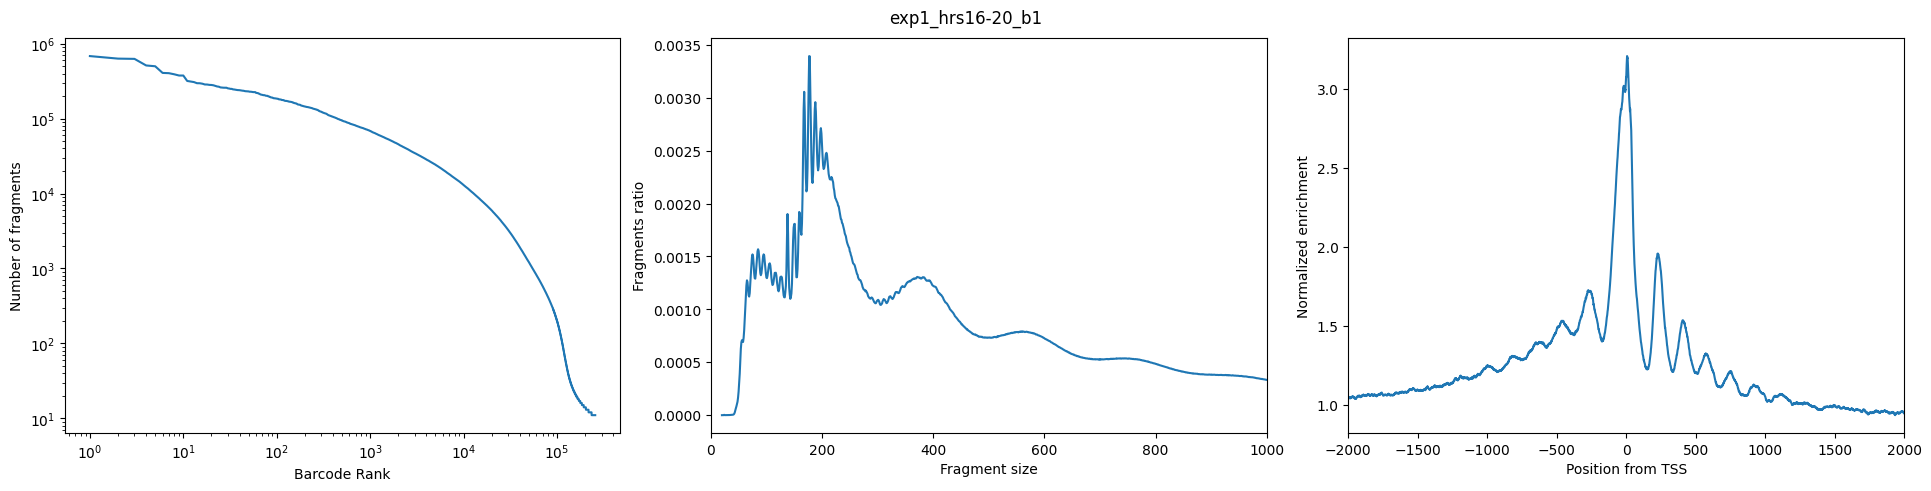

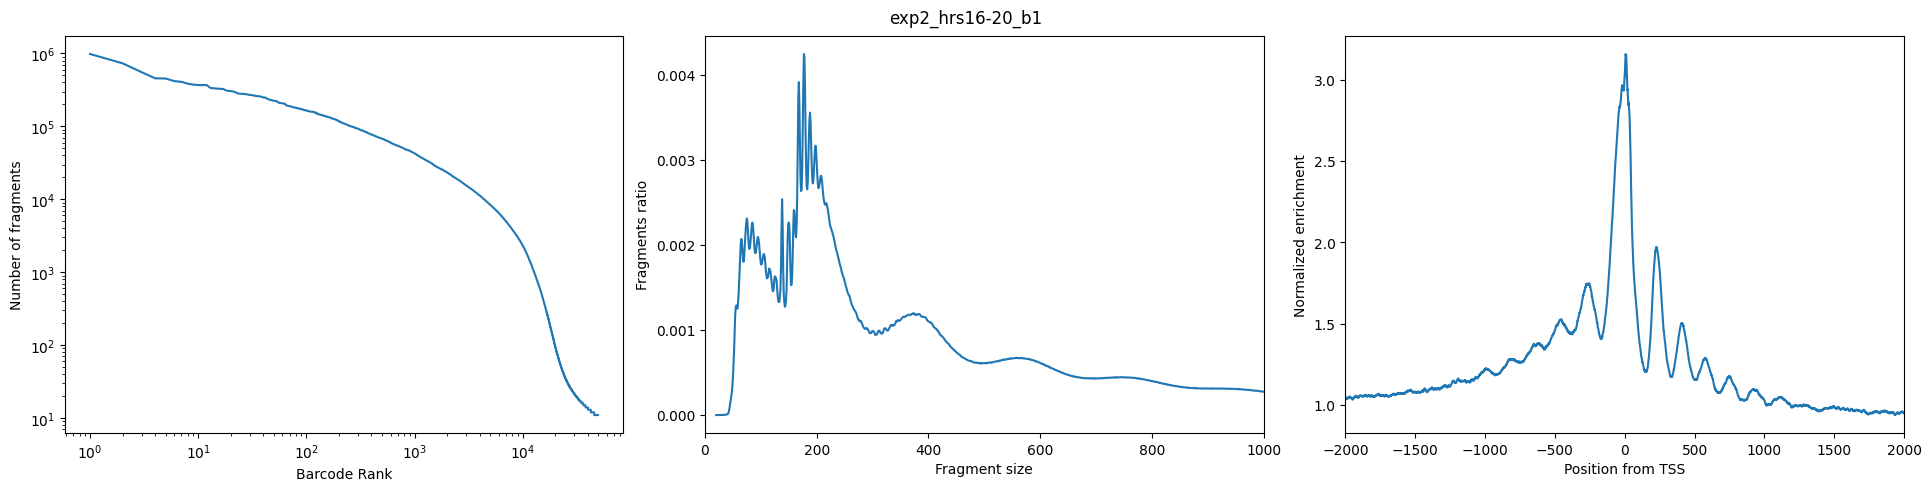

In [11]:
for sample_id in fragments_dict:
    fig = plot_sample_stats(
        sample_id = sample_id,
        pycistopic_qc_output_dir = os.path.join(out_dir, 'QC'), 
        save = out_dir + 'QC/sample_stats_plot.svg'
    )

In [8]:
# used 800 and 2 as thresholds because otsu was higher (just as in PUMATAC this was taken as max filter value)
from pycisTopic.qc import get_barcodes_passing_qc_for_sample
sample_id_to_barcodes_passing_filters = {}
sample_id_to_thresholds = {}
for sample_id in fragments_dict:
    (
        sample_id_to_barcodes_passing_filters[sample_id],
        sample_id_to_thresholds[sample_id]
    ) = get_barcodes_passing_qc_for_sample(
            sample_id = sample_id,
            pycistopic_qc_output_dir = out_dir +"QC",
            unique_fragments_threshold = 800, #np.log10(800), # don't use automatic thresholding
            tss_enrichment_threshold = 2, # don't use automatic thresholding
            frip_threshold = None,
            use_automatic_thresholds = True,
    )

exp1_hrs16-20_b1:
	Using user-defined threshold for unique fragments: 800
	Using user-defined threshold for TSS enrichment: 2
	No threshold for FRiP defined, setting to 0
exp2_hrs16-20_b1:
	Using user-defined threshold for unique fragments: 800
	Using user-defined threshold for TSS enrichment: 2
	No threshold for FRiP defined, setting to 0


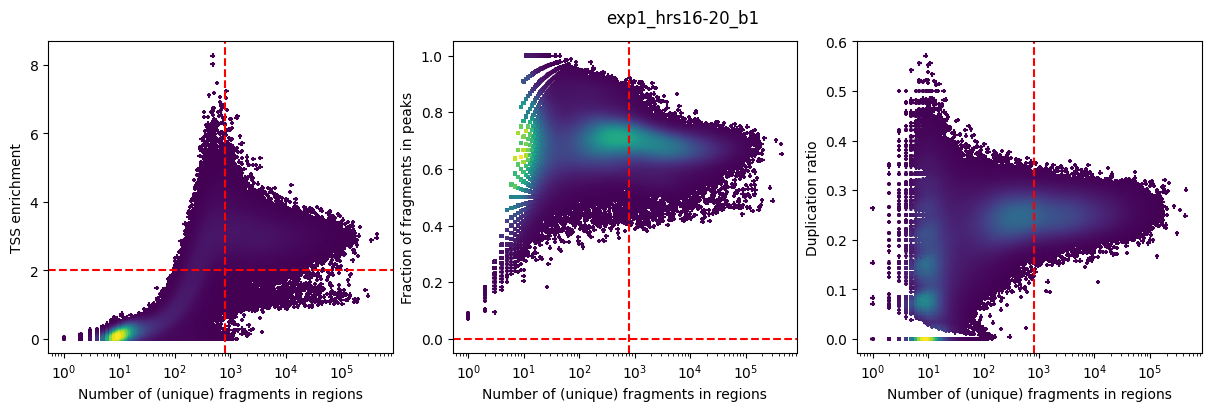

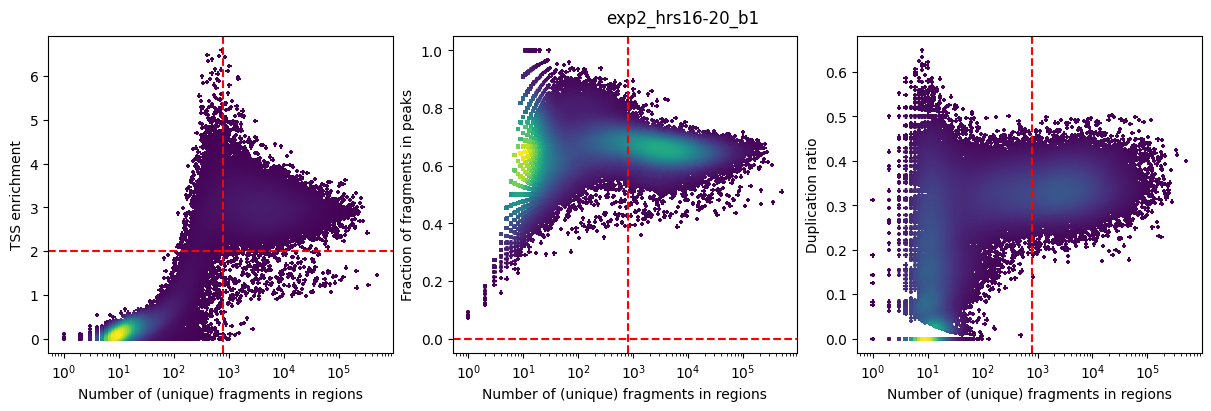

In [9]:
for sample_id in fragments_dict:
    fig = plot_barcode_stats(
        sample_id = sample_id,
        pycistopic_qc_output_dir = out_dir +"QC",
        bc_passing_filters = sample_id_to_barcodes_passing_filters[sample_id],
        detailed_title = False,
        **sample_id_to_thresholds[sample_id]
    )

In [13]:
path_to_regions = '/staging/leuven/stg_00002/lcb/hdickm/resources/consensus_peaks/consensus_peaks_sciATAC_embryoatlas_16_20hAEL.bed' #dev_consensuspeaks
path_to_blacklist = "/staging/leuven/stg_00002/lcb/hdickm/resources/dm6-blacklist-nochr.v2.bed"
pycistopic_qc_output_dir = out_dir +"QC"

from pycisTopic.cistopic_class import create_cistopic_object_from_fragments
import polars as pl

In [14]:
#no duplication filter possible? run scrublet
import polars as pl
cistopic_obj_list = []
for sample_id in fragments_dict:
    sample_metrics = pl.read_parquet(
        os.path.join(pycistopic_qc_output_dir, f'{sample_id}.fragments_stats_per_cb.parquet')
    ).to_pandas().set_index("CB").loc[ sample_id_to_barcodes_passing_filters[sample_id] ]
    cistopic_obj = create_cistopic_object_from_fragments(
        path_to_fragments = fragments_dict[sample_id],
        path_to_regions = path_to_regions,
        path_to_blacklist = path_to_blacklist,
        metrics = sample_metrics,
        valid_bc = sample_id_to_barcodes_passing_filters[sample_id],
        n_cpu = 2,
        project = sample_id,
        split_pattern = '-'
    )
    cistopic_obj_list.append(cistopic_obj)

2024-07-16 12:55:54,557 cisTopic     INFO     Reading data for exp1_hrs16-20_b1
2024-07-16 13:03:02,759 cisTopic     INFO     metrics provided!
2024-07-16 13:03:35,127 cisTopic     INFO     Counting fragments in regions


2024-07-16 13:03:35,630	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-07-16 13:03:39,823	INFO worker.py:1724 -- Started a local Ray instance.


2024-07-16 13:08:40,400 cisTopic     INFO     Creating fragment matrix


/opt/venv/lib/python3.11/site-packages/pycisTopic/cistopic_class.py:872: PerformanceWarning: The following operation may generate 3329891960 cells in the resulting pandas object.
  .unstack(level="Name", fill_value=0)


2024-07-16 13:12:07,419 cisTopic     INFO     Converting fragment matrix to sparse matrix
2024-07-16 13:12:35,634 cisTopic     INFO     Removing blacklisted regions
2024-07-16 13:12:36,463 cisTopic     INFO     Creating CistopicObject
2024-07-16 13:12:44,218 cisTopic     INFO     Done!
2024-07-16 13:12:54,149 cisTopic     INFO     Reading data for exp2_hrs16-20_b1
2024-07-16 13:15:07,708 cisTopic     INFO     metrics provided!
2024-07-16 13:15:18,580 cisTopic     INFO     Counting fragments in regions


2024-07-16 13:15:23,116	INFO worker.py:1724 -- Started a local Ray instance.


2024-07-16 13:17:06,160 cisTopic     INFO     Creating fragment matrix
2024-07-16 13:18:01,784 cisTopic     INFO     Converting fragment matrix to sparse matrix
2024-07-16 13:18:09,471 cisTopic     INFO     Removing blacklisted regions
2024-07-16 13:18:09,840 cisTopic     INFO     Creating CistopicObject
2024-07-16 13:18:12,114 cisTopic     INFO     Done!


In [15]:
cistopic_obj_list

In [16]:
import pickle
pickle.dump(
    cistopic_obj_list,
    open(os.path.join(out_dir, "cistopic_objs/cistopic_obj_list_tss2_frag800.pkl"), "wb")
)

In [17]:
from pycisTopic.cistopic_class import *
cistopic_obj = merge(cistopic_obj_list)
print(cistopic_obj)

2024-07-16 13:23:20,075 cisTopic     INFO     cisTopic object 1 merged
CistopicObject from project cisTopic_merge with n_cells × n_regions = 61480 × 67162


In [18]:
import pickle
pickle.dump(
    cistopic_obj,
    open(os.path.join(out_dir, "cistopic_objs/cistopic_obj_sciATAC_16_20hAEL_16072024.pkl"), "wb")
)

In [19]:
print(cistopic_obj)

CistopicObject from project cisTopic_merge with n_cells × n_regions = 61480 × 67162


# scrublet

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.18
Detected doublet rate = 24.2%
Estimated detectable doublet fraction = 63.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 38.0%
Elapsed time: 209.1 seconds


(<Figure size 800x300 with 2 Axes>,
 array([<AxesSubplot: title={'center': 'Observed transcriptomes'}, xlabel='Doublet score', ylabel='Prob. density'>,
        <AxesSubplot: title={'center': 'Simulated doublets'}, xlabel='Doublet score', ylabel='Prob. density'>],
       dtype=object))

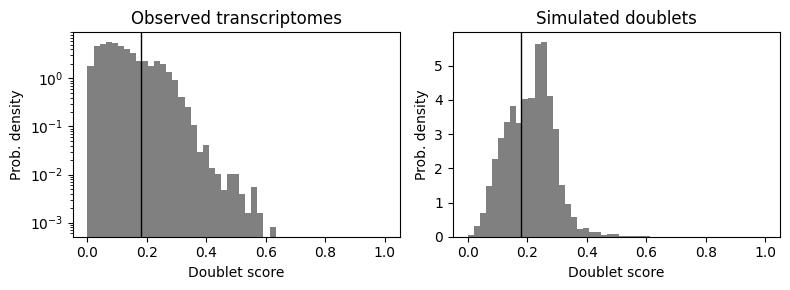

In [20]:
import scrublet as scr
scrub = scr.Scrublet(cistopic_obj.fragment_matrix.T, expected_doublet_rate=0.1)
doublet_scores, predicted_doublets = scrub.scrub_doublets()
scrub.plot_histogram()

In [21]:
import pandas as pd
scrublet = pd.DataFrame([scrub.doublet_scores_obs_, scrub.predicted_doublets_], columns=cistopic_obj.cell_names, index=['Doublet_scores_fragments', 'Predicted_doublets_fragments']).T

In [22]:
cistopic_obj.add_cell_data(scrublet, split_pattern = '-')
print(sum(cistopic_obj.cell_data.Predicted_doublets_fragments == True))
print(sum(cistopic_obj.cell_data.Predicted_doublets_fragments == False))

14895
46585


In [23]:
# Remove doublets
singlets = cistopic_obj.cell_data[cistopic_obj.cell_data.Predicted_doublets_fragments == False].index.tolist()
# Subset cisTopic object
cistopic_obj_noDBL = cistopic_obj.subset(singlets, copy=True, split_pattern='-')
print(cistopic_obj_noDBL)
print(cistopic_obj)

CistopicObject from project cisTopic_merge with n_cells × n_regions = 46585 × 67162
CistopicObject from project cisTopic_merge with n_cells × n_regions = 61480 × 67162


In [24]:
pickle.dump(
    cistopic_obj,
    open(os.path.join(out_dir, "cistopic_objs/cistopic_obj_sciATAC_16_20hAEL_16072024.pkl"), "wb")
)

In [25]:
pickle.dump(
    cistopic_obj_noDBL,
    open(os.path.join(out_dir, "cistopic_objs/cistopic_obj_sciATAC_16_20hAEL_16072024_noDBL.pkl"), "wb")
)

In [26]:
out_dir

'/lustre1/project/stg_00002/lcb/hydrop_v2_paper/fly/sci_ATAC/'

# topic modeling - rerun with all cells included model

In [5]:
# Load cisTopic object - rerunning topic modeling
import pickle
infile = open(os.path.join(out_dir, "cistopic_objs/cistopic_obj_sciATAC_16_20hAEL_16072024.pkl"), 'rb')
cistopic_obj = pickle.load(infile)
infile.close()

FileNotFoundError: [Errno 2] No such file or directory: '/lustre1/project/stg_00002/lcb/hydrop_v2_paper/fly/sci_ATAC/cistopic_objs/cistopic_obj_sciATAC_16_20hAEL_16072024.pkl'

In [6]:
# load gzipped pickle obj
import gzip
import pickle

# Define the path to the gzipped pickle file
gzip_pickle_path = out_dir + 'cistopic_objs/cistopic_obj_sciATAC_16_20hAEL_16072024.pkl.gz'

# Open and load the gzipped pickle file
with gzip.open(gzip_pickle_path, 'rb') as infile:
    cistopic_obj = pickle.load(infile)

In [7]:
cistopic_obj.cell_data

cisTopic_nr_frag  \
AATGCTCTGAAATACCTGCCCCAATTCCATCGCCGGTATG-exp1_h...            22941   
TGGTTACGCTAATACCTGCCGTTCGAGGCGATTCATCGCC-exp1_h...            25908   
CTGGATGCCACCGAAGGTTATCTCATTGCCAATGCAGCGG-exp1_h...            50760   
GCGGTCAGAGTCCAATGGTTAATATAGCGGCGCCGGTATG-exp1_h...             4566   
GTTCGGCCTTAGCATACGGCCCAATTCCATGCAGCAGCTA-exp1_h...            97917   
...                                                             ...   
ATCATCAGAACGGACTGGCCTTCTAATCCGGTACGATTCT-exp2_h...              994   
TCTCGAAGGCGCATTAGGCGACCAGTTCAGGCAGCAGCTA-exp2_h...             2142   
GCGCAGGCGATGACGCGACCTGGCCGTCTTTCAATTCAAC-exp2_h...             1848   
GTATAAGGCATAATTCCGGTCTTCAGTAGTGCAGCAGCTA-exp2_h...             3174   
GTAATCGCAATGGTATCAGAGTTCGTCTGATTATACTGCA-exp2_h...             1983   

                                                   cisTopic_log_nr_frag  \
AATGCTCTGAAATACCTGCCCCAATTCCATCGCCGGTATG-exp1_h...             4.360612   
TGGTTACGCTAATACCTGCCGTTCGAGGCGATTCATCGCC-exp1_h...             4.413434   
CTGGATGCCACCGAAGGTTATCTCATTGCCAATGCAGCGG-exp1_h...             4.705522   
GCGGTCAGAGTCCAATGGTTAATATAGCGGCGCCGGTATG-exp1_h...             3.659536   
GTTCGGCCTTAGCATACGGCCCAATTCCATGCAGCAGCTA-exp1_h...             4.990858   
...                                                                 ...   
ATCATCAGAACGGACTGGCCTTCTAATCCGGTACGATTCT-exp2_h...             2.997386   
TCTCGAAGGCGCATTAGGCGACCAGTTCAGGCAGCAGCTA-exp2_h...             3.330819   
GCGCAGGCGATGACGCGACCTGGCCGTCTTTCAATTCAAC-exp2_h...             3.266702   
GTATAAGGCATAATTCCGGTCTTCAGTAGTGCAGCAGCTA-exp2_h...             3.501607   
GTAATCGCAATGGTATCAGAGTTCGTCTGATTATACTGCA-exp2_h...             3.297323   

                                                   cisTopic_nr_acc  \
AATGCTCTGAAATACCTGCCCCAATTCCATCGCCGGTATG-exp1_h...           18357   
TGGTTACGCTAATACCTGCCGTTCGAGGCGATTCATCGCC-exp1_h...           20497   
CTGGATGCCACCGAAGGTTATCTCATTGCCAATGCAGCGG-exp1_h...           29208   
GCGGTCAGAGTCCAATGGTTAATATAGCGGCGCCGGTATG-exp1_h...            4228   
GTTCGGCCTTAGCATACGGCCCAATTCCATGCAGCAGCTA-exp1_h...           43213   
...                                                            ...   
ATCATCAGAACGGACTGGCCTTCTAATCCGGTACGATTCT-exp2_h...             961   
TCTCGAAGGCGCATTAGGCGACCAGTTCAGGCAGCAGCTA-exp2_h...            1937   
GCGCAGGCGATGACGCGACCTGGCCGTCTTTCAATTCAAC-exp2_h...            1741   
GTATAAGGCATAATTCCGGTCTTCAGTAGTGCAGCAGCTA-exp2_h...            2974   
GTAATCGCAATGGTATCAGAGTTCGTCTGATTATACTGCA-exp2_h...            1858   

                                                   cisTopic_log_nr_acc  \
AATGCTCTGAAATACCTGCCCCAATTCCATCGCCGGTATG-exp1_h...            4.263802   
TGGTTACGCTAATACCTGCCGTTCGAGGCGATTCATCGCC-exp1_h...             4.31169   
CTGGATGCCACCGAAGGTTATCTCATTGCCAATGCAGCGG-exp1_h...            4.465502   
GCGGTCAGAGTCCAATGGTTAATATAGCGGCGCCGGTATG-exp1_h...            3.626135   
GTTCGGCCTTAGCATACGGCCCAATTCCATGCAGCAGCTA-exp1_h...            4.635614   
...                                                                ...   
ATCATCAGAACGGACTGGCCTTCTAATCCGGTACGATTCT-exp2_h...            2.982723   
TCTCGAAGGCGCATTAGGCGACCAGTTCAGGCAGCAGCTA-exp2_h...             3.28713   
GCGCAGGCGATGACGCGACCTGGCCGTCTTTCAATTCAAC-exp2_h...            3.240799   
GTATAAGGCATAATTCCGGTCTTCAGTAGTGCAGCAGCTA-exp2_h...            3.473341   
GTAATCGCAATGGTATCAGAGTTCGTCTGATTATACTGCA-exp2_h...            3.269046   

                                                           sample_id  \
AATGCTCTGAAATACCTGCCCCAATTCCATCGCCGGTATG-exp1_h...  exp1_hrs16-20_b1   
TGGTTACGCTAATACCTGCCGTTCGAGGCGATTCATCGCC-exp1_h...  exp1_hrs16-20_b1   
CTGGATGCCACCGAAGGTTATCTCATTGCCAATGCAGCGG-exp1_h...  exp1_hrs16-20_b1   
GCGGTCAGAGTCCAATGGTTAATATAGCGGCGCCGGTATG-exp1_h...  exp1_hrs16-20_b1   
GTTCGGCCTTAGCATACGGCCCAATTCCATGCAGCAGCTA-exp1_h...  exp1_hrs16-20_b1   
...                                                              ...   
ATCATCAGAACGGACTGGCCTTCTAATCCGGTACGATTCT-exp2_h...  exp2_hrs16-

In [8]:
import os
import pickle
model_folder = out_dir +"cistopic_objs/models/"
models = [
   pickle.load(open(os.path.join(model_folder, model_fname), "rb"))
   for model_fname in os.listdir(model_folder)]

2024-08-14 08:09:03,259	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


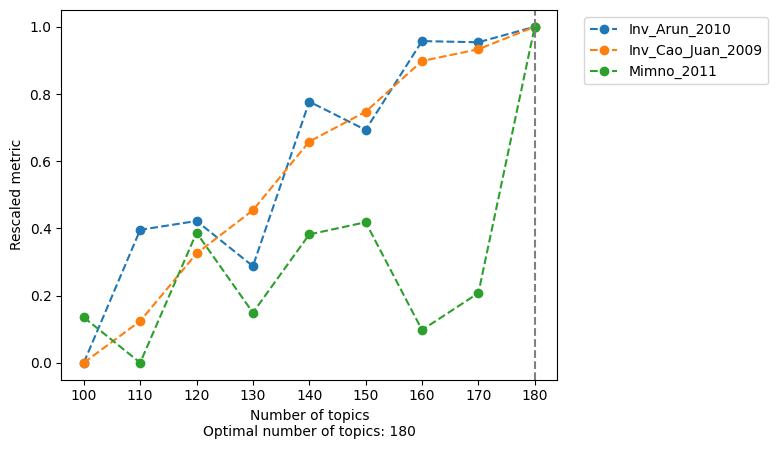

In [9]:
from pycisTopic.lda_models import evaluate_models
model = evaluate_models(
    models,
    select_model = None,
    metrics=['Arun_2010','Cao_Juan_2009', 'Minmo_2011'],
    return_model = True
)

In [10]:
cistopic_obj.add_LDA_model(model)

In [11]:
import pickle
pickle.dump(
    cistopic_obj,
    open(os.path.join(out_dir, "cistopic_objs/cistopic_obj_sciATAC_16_20hAEL_16072024_180topics.pkl"), "wb")
)

In [12]:
cistopic_obj.projections = {"cell": {}, "region": {}}

In [13]:
find_clusters(
    cistopic_obj,
    target  = 'cell',
    k = 10,
    res = [1.2],
    prefix = 'pycisTopic_',
    scale = True,
    split_pattern = '-'
)

2024-08-14 08:09:35,875 cisTopic     INFO     Finding neighbours


In [14]:
run_umap(
    cistopic_obj,
    target  = 'cell', scale=True)

2024-08-14 08:09:48,997 cisTopic     INFO     Running UMAP


/opt/venv/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [15]:
run_tsne(
    cistopic_obj,
    target  = 'cell', scale=True)

2024-08-14 08:10:56,811 cisTopic     INFO     Running TSNE


In [39]:
import pickle
pickle.dump(
    cistopic_obj,
    open(os.path.join(out_dir, "cistopic_objs/cistopic_obj_sciATAC_16_20hAEL_16072024_180topics.pkl"), "wb")
)

### visualization

In [3]:
#after models - models are submitted
# Load cisTopic object
import pickle
infile = open(out_dir + 'cistopic_objs/cistopic_obj_sciATAC_16_20hAEL_16072024_180topics.pkl', 'rb')
cistopic_obj = pickle.load(infile)
infile.close()

2024-07-16 15:08:37,166	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [17]:
print(cistopic_obj.cell_data.columns)

Index(['cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc',
       'cisTopic_log_nr_acc', 'sample_id', 'barcode_rank',
       'total_fragments_count', 'log10_total_fragments_count',
       'unique_fragments_count', 'log10_unique_fragments_count',
       'total_fragments_in_peaks_count',
       'log10_total_fragments_in_peaks_count',
       'unique_fragments_in_peaks_count',
       'log10_unique_fragments_in_peaks_count',
       'fraction_of_fragments_in_peaks', 'duplication_count',
       'duplication_ratio', 'tss_enrichment', 'pdf_values_for_tss_enrichment',
       'pdf_values_for_fraction_of_fragments_in_peaks',
       'pdf_values_for_duplication_ratio', 'barcode',
       'Doublet_scores_fragments', 'Predicted_doublets_fragments',
       'pycisTopic_leiden_10_1.2'],
      dtype='object')


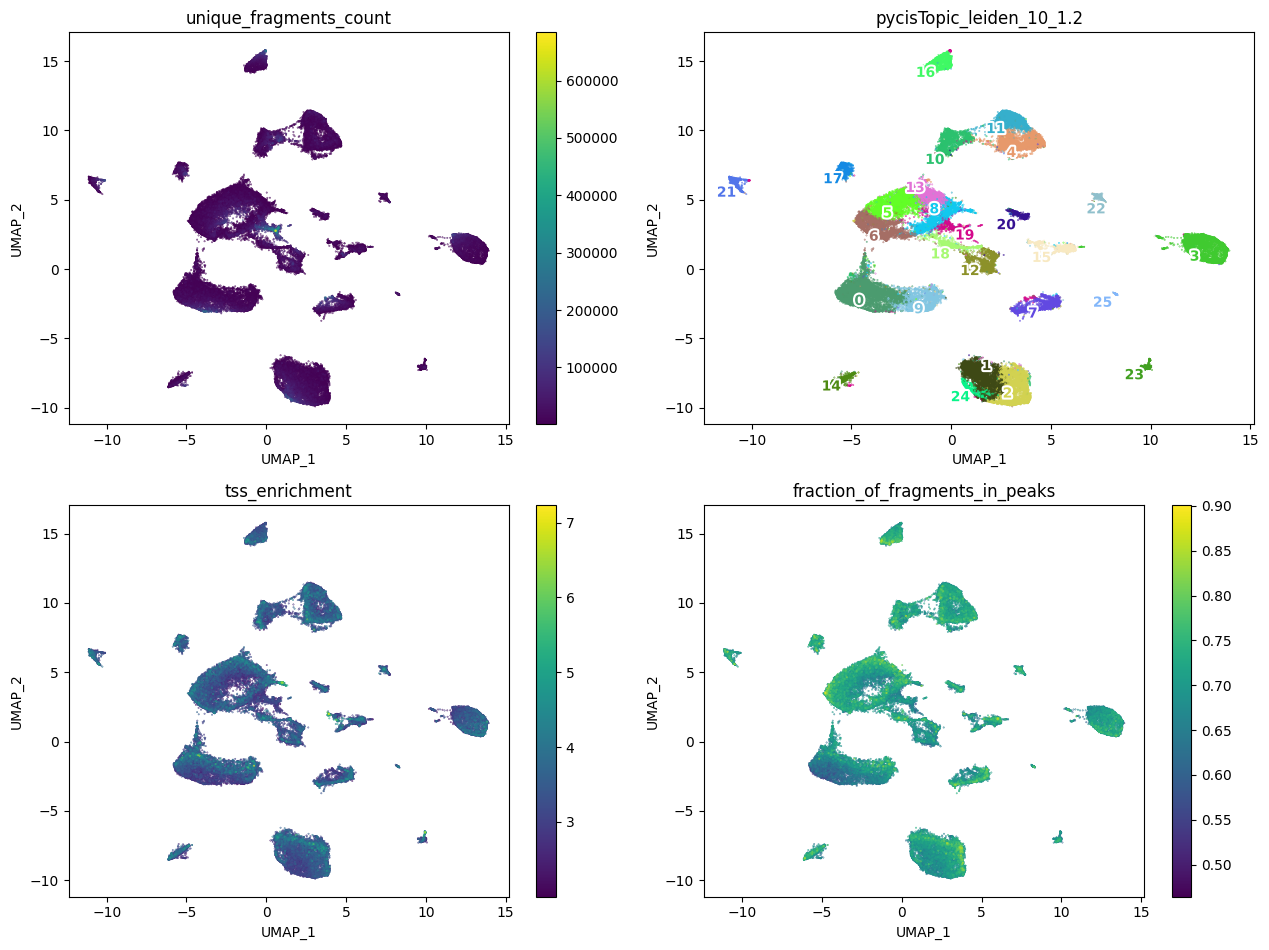

In [18]:
# model 180 including doublets
plot_metadata(
    cistopic_obj,
    reduction_name='UMAP',
    variables=['unique_fragments_count', 'pycisTopic_leiden_10_1.2', 'tss_enrichment', 'fraction_of_fragments_in_peaks'],
    target='cell', num_columns=2,
    remove_nan = False,
    text_size=10,
    dot_size=0.1)

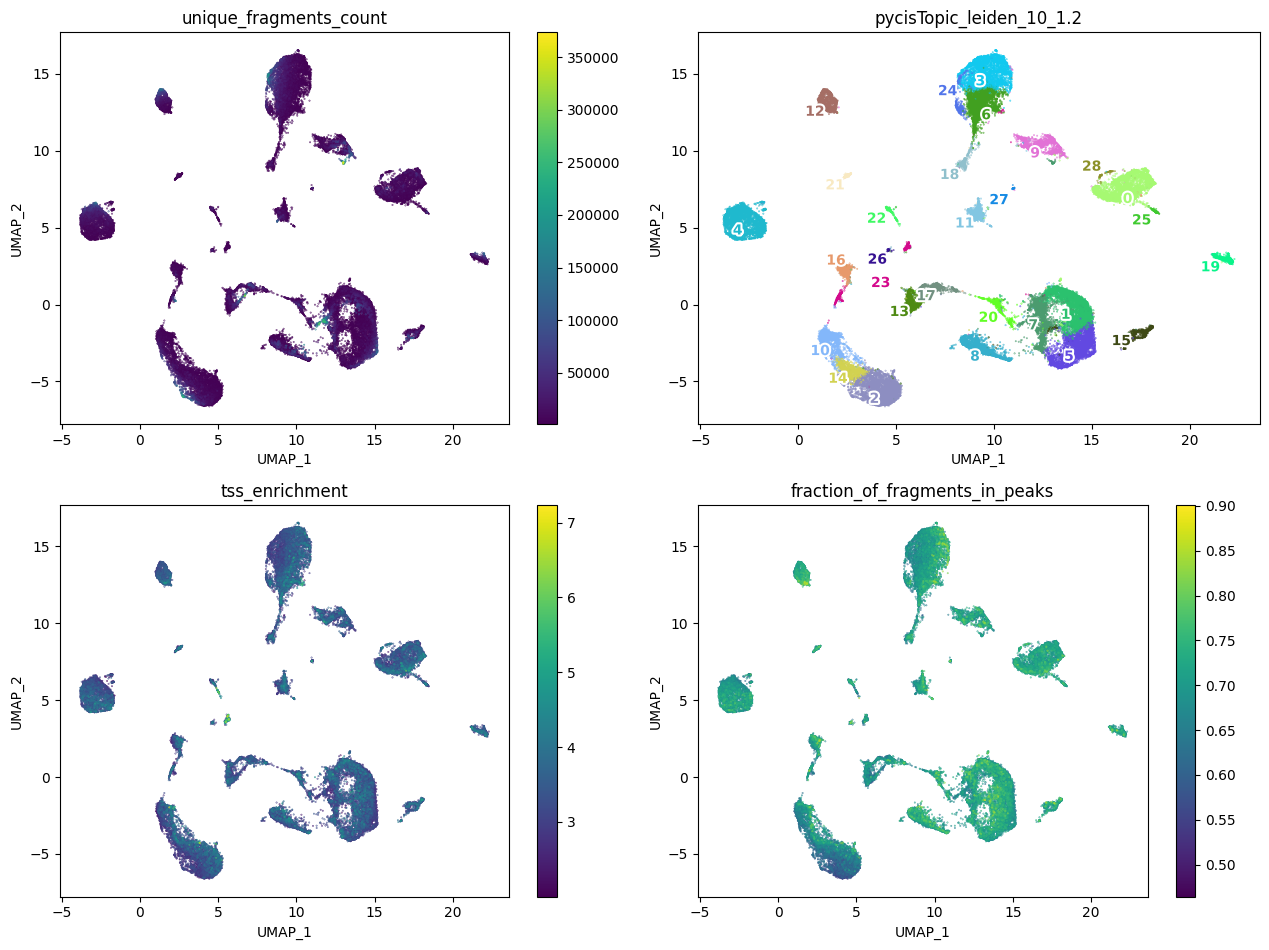

In [15]:
# model 320
plot_metadata(
    cistopic_obj,
    reduction_name='UMAP',
    variables=['unique_fragments_count', 'pycisTopic_leiden_10_1.2', 'tss_enrichment', 'fraction_of_fragments_in_peaks'],
    target='cell', num_columns=2,
    remove_nan = False,
    text_size=10,
    dot_size=0.1)

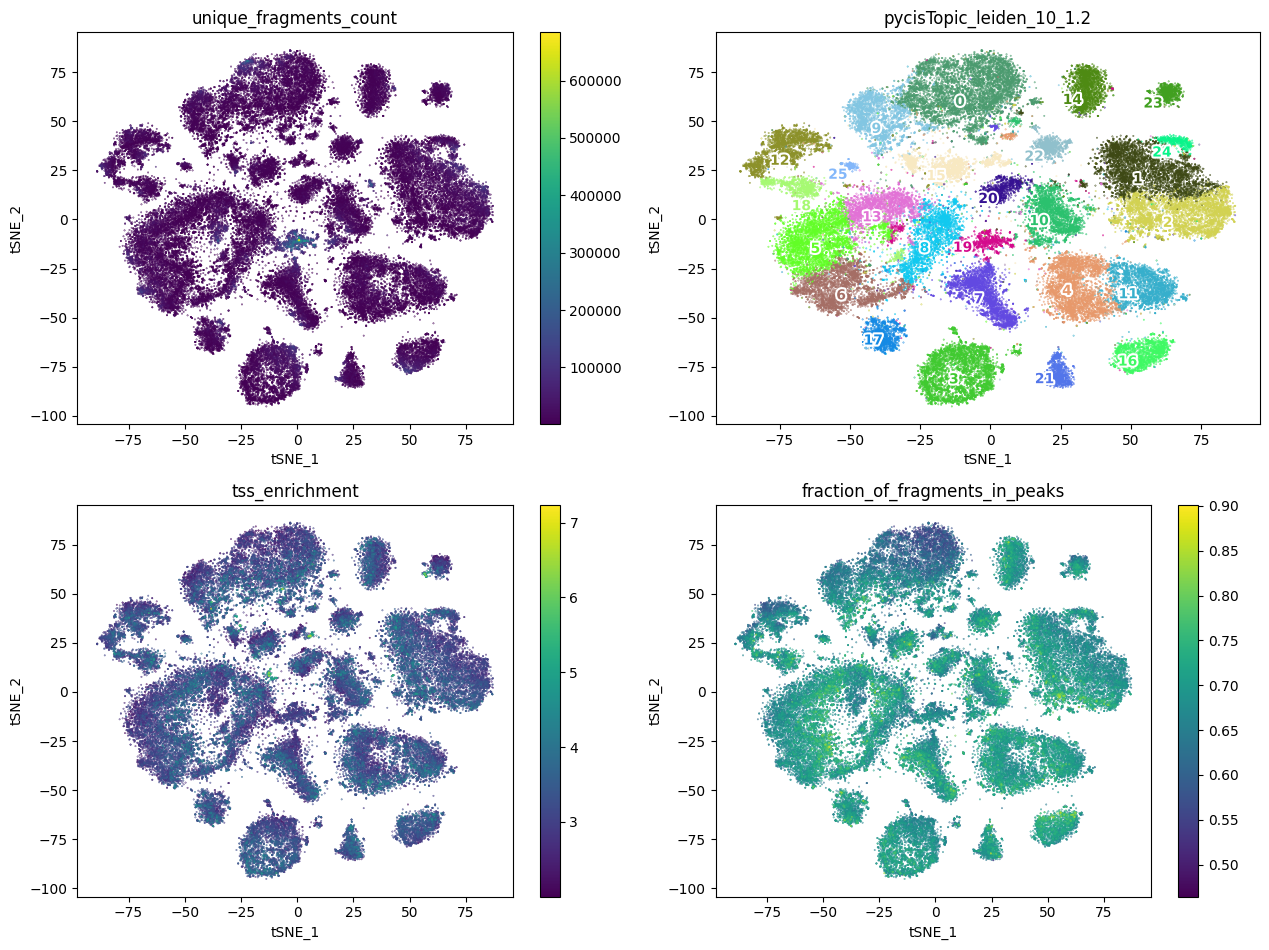

In [19]:
# model 180 including doublets
plot_metadata(
    cistopic_obj,
    reduction_name='tSNE',
    variables=['unique_fragments_count', 'pycisTopic_leiden_10_1.2', 'tss_enrichment', 'fraction_of_fragments_in_peaks'],
    target='cell', num_columns=2,
    remove_nan = False,
    text_size=10,
    dot_size=0.1)

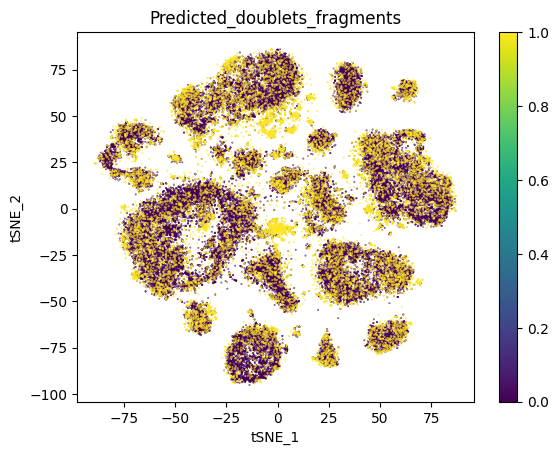

In [20]:
# model 180 including doublets
plot_metadata(
    cistopic_obj,
    reduction_name='tSNE',
    variables=['Predicted_doublets_fragments'],
    target='cell', num_columns=1,
    remove_nan = False,
    text_size=10,
    dot_size=0.1)

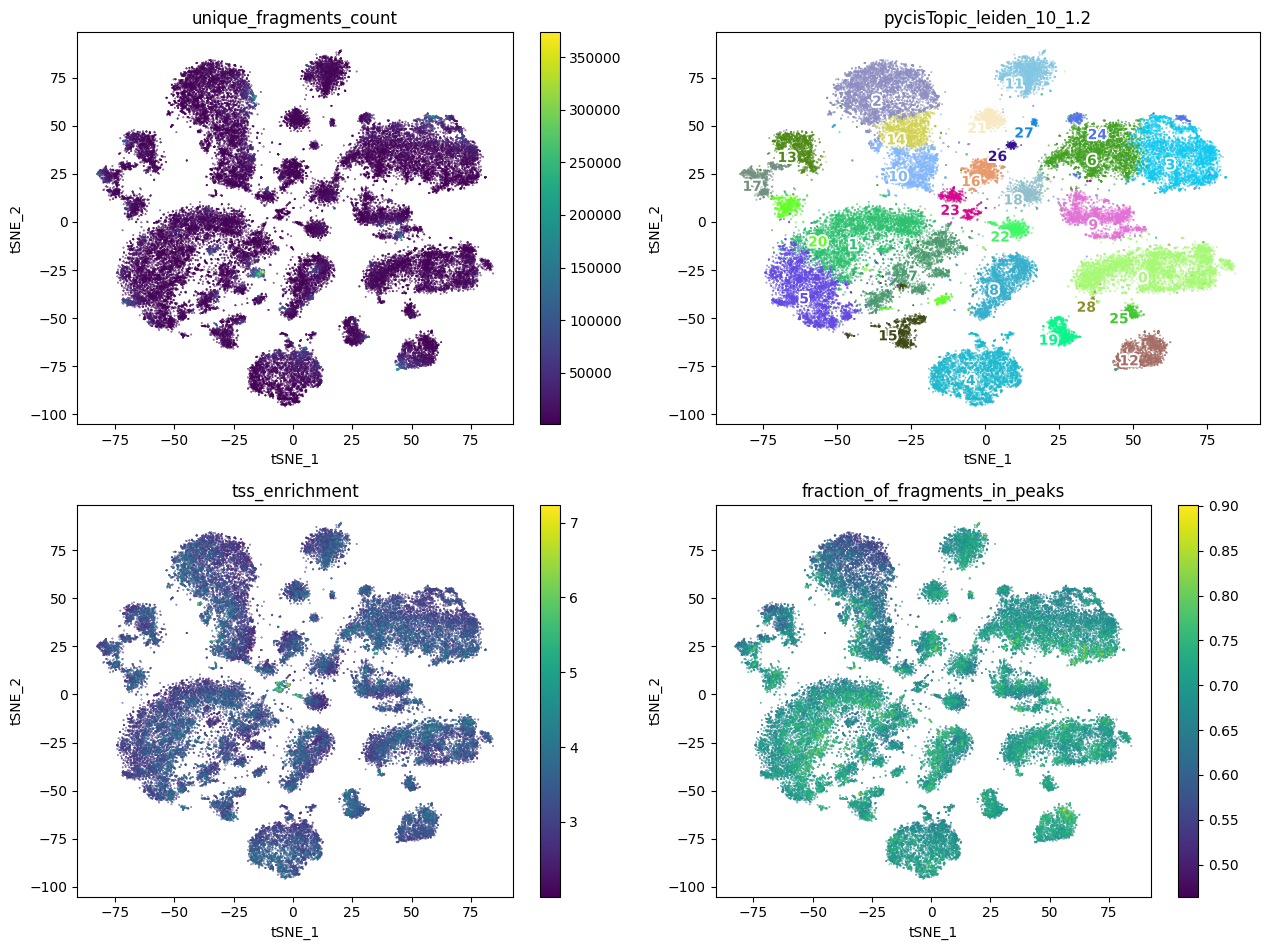

In [16]:
# model 320
plot_metadata(
    cistopic_obj,
    reduction_name='tSNE',
    variables=['unique_fragments_count', 'pycisTopic_leiden_10_1.2', 'tss_enrichment', 'fraction_of_fragments_in_peaks'],
    target='cell', num_columns=2,
    remove_nan = False,
    text_size=10,
    dot_size=0.1)

# annotations

In [22]:
import pandas as pd

In [23]:
# Get metadata
# cell_data = pd.read_feather('/data/leuven/339/vsc33906/rstudio/fly/model_to_pycisTopic/larval_cell_data.feather')
cell_data = pd.read_csv("/staging/leuven/stg_00002/lcb/hdickm/projects/embryo_data/atac_meta_embryo_atlas.csv")

In [24]:
cell_data

cell  doublet_score   exp   time  \
0       CTATGGTTCGTTCCATTCTTTCTCATTGCCCTCTGCGATC       0.802721  exp1  03-07   
1       AGATAATTCCTTCCATTCTTAGTCGCGTCGAAGTTCGCTG       0.700680  exp1  03-07   
2       TCCTCTTAACCTAGCTTCTTGTAGTAGTCCTGATTCTCGT       0.505102  exp1  03-07   
3       ACGGCAAGCAATATCTTCCGGAGCTCAGCCCCTACTCAAC       0.653061  exp1  03-07   
4       AACTTACGCTCATTCTGATGCCAATTCCATGTCGTTCGCC       0.671769  exp1  03-07   
...                                          ...            ...   ...    ...   
976451  ACGTCTCCTCTAATTCCGGTGGCAATCAAGATTCATCGCC       0.578947  exp2  16-20   
976452  GTAATCGCAATCAACGAGGTGCCAAGGCAACCGATACTCT       0.438596  exp2  16-20   
976453  TCTCAGCGGCTTCTCTACGATGGCCGTCTTTTGCATGAGG       0.485380  exp2  16-20   
976454  GTCTTGATGCATATGGTACCGACCTCCTTGGTTCAATTGC       0.678363  exp2  16-20   
976455  TCGGCGTACCTCATCAGCCAATCTAGTTAGGTACGATTCT       0.684211  exp2  16-20   

                  sample  seurat_clusters  lasso_age   NNv1_age  \
0       exp1_hrs03-07_b1                7  -3.110988   1.690188   
1       exp1_hrs03-07_b1                6  -1.039036   1.330054   
2       exp1_hrs03-07_b1                1  -3.924070   1.984080   
3       exp1_hrs03-07_b1                1   2.537512   1.861791   
4       exp1_hrs03-07_b1                1  -1.401258   1.801240   
...                  ...              ...        ...        ...   
976451  exp2_hrs16-20_b1                1  16.530663  18.050606   
976452  exp2_hrs16-20_b1                1  13.830964  18.161829   
976453  exp2_hrs16-20_b1                6  13.637865  18.004314   
976454  exp2_hrs16-20_b1                2  15.223159  18.131519   
976455  exp2_hrs16-20_b1                5  17.833629  18.085754   

       lasso_time.new NNv1_time.new  seurat_clusters.predtime  \
0               00-02         00-02                         3   
1               00-02         00-02                         1   
2               00-02         00-02                         1   
3               02-04         00-02                         2   
4               00-02         00-02                         2   
...               ...           ...                       ...   
976451          16-18         18-20                         1   
976452          12-14         18-20                         2   
976453          12-14         18-20                         0   
976454          14-16         18-20                         0   
976455          16-18         18-20                         1   

       refined_annotation  
0              Blastoderm  
1              Blastoderm  
2              Blastoderm  
3              Blastoderm  
4              Blastoderm  
...                   ...  
976451            Pharnyx  
976452          Epidermis  
976453     Somatic muscle  
976454     Somatic muscle  
976455            Pharnyx  

[976456 rows x 12 columns]

In [25]:
annotations = cell_data.refined_annotation
cell_ids = cell_data.cell
cell_id_to_annot = {cell_id: annot for cell_id, annot in zip(cell_ids, annotations)}

In [26]:
d_s1 = {f"{cell_id.split('___')[0]}-exp1_hrs16-20_b1___exp1_hrs16-20_b1": cell_id_to_annot[cell_id] for cell_id in cell_id_to_annot}
d_s2 = {f"{cell_id.split('___')[0]}-exp2_hrs16-20_b1___exp2_hrs16-20_b1": cell_id_to_annot[cell_id] for cell_id in cell_id_to_annot}

#merge dictionaries
cell_id_corrected_brain = {**d_s1, **d_s2}

In [27]:
cistopic_obj.cell_data['embryo_annotations'] = cistopic_obj.cell_data.index.map(cell_id_corrected_brain)

In [43]:
cistopic_obj.cell_data['embryo_annotations'] = cistopic_obj.cell_data.index.map(cell_id_corrected_brain)

In [28]:
cistopic_obj.cell_data[cistopic_obj.cell_data['sample_id'] == 'exp2_hrs16-20_b1'd]

cisTopic_nr_frag  \
GGAACGCCTAATCCTTCAACATGCCTCTTCGTCCTCAGAA-exp2_h...            20409   
CTGGCTTAGTGATCATGATATGGCCGTCTTGCTGGTTATA-exp2_h...            38093   
TGAATTATGACGGCATCTTGATGAATACCAGCTTACCGCC-exp2_h...           129517   
ATTATACTACGGTACTTCCAACCAGTTCAGATACTTGATT-exp2_h...            32991   
GGCCATACTTGGTACTTCCAGACCTCCTTGGGTTCGACCT-exp2_h...            15284   
...                                                             ...   
ATCATCAGAACGGACTGGCCTTCTAATCCGGTACGATTCT-exp2_h...              994   
TCTCGAAGGCGCATTAGGCGACCAGTTCAGGCAGCAGCTA-exp2_h...             2142   
GCGCAGGCGATGACGCGACCTGGCCGTCTTTCAATTCAAC-exp2_h...             1848   
GTATAAGGCATAATTCCGGTCTTCAGTAGTGCAGCAGCTA-exp2_h...             3174   
GTAATCGCAATGGTATCAGAGTTCGTCTGATTATACTGCA-exp2_h...             1983   

                                                   cisTopic_log_nr_frag  \
GGAACGCCTAATCCTTCAACATGCCTCTTCGTCCTCAGAA-exp2_h...             4.309822   
CTGGCTTAGTGATCATGATATGGCCGTCTTGCTGGTTATA-exp2_h...             4.580845   
TGAATTATGACGGCATCTTGATGAATACCAGCTTACCGCC-exp2_h...             5.112327   
ATTATACTACGGTACTTCCAACCAGTTCAGATACTTGATT-exp2_h...             4.518395   
GGCCATACTTGGTACTTCCAGACCTCCTTGGGTTCGACCT-exp2_h...             4.184237   
...                                                                 ...   
ATCATCAGAACGGACTGGCCTTCTAATCCGGTACGATTCT-exp2_h...             2.997386   
TCTCGAAGGCGCATTAGGCGACCAGTTCAGGCAGCAGCTA-exp2_h...             3.330819   
GCGCAGGCGATGACGCGACCTGGCCGTCTTTCAATTCAAC-exp2_h...             3.266702   
GTATAAGGCATAATTCCGGTCTTCAGTAGTGCAGCAGCTA-exp2_h...             3.501607   
GTAATCGCAATGGTATCAGAGTTCGTCTGATTATACTGCA-exp2_h...             3.297323   

                                                   cisTopic_nr_acc  \
GGAACGCCTAATCCTTCAACATGCCTCTTCGTCCTCAGAA-exp2_h...           16888   
CTGGCTTAGTGATCATGATATGGCCGTCTTGCTGGTTATA-exp2_h...           25785   
TGAATTATGACGGCATCTTGATGAATACCAGCTTACCGCC-exp2_h...           48741   
ATTATACTACGGTACTTCCAACCAGTTCAGATACTTGATT-exp2_h...           23087   
GGCCATACTTGGTACTTCCAGACCTCCTTGGGTTCGACCT-exp2_h...           12422   
...                                                            ...   
ATCATCAGAACGGACTGGCCTTCTAATCCGGTACGATTCT-exp2_h...             961   
TCTCGAAGGCGCATTAGGCGACCAGTTCAGGCAGCAGCTA-exp2_h...            1937   
GCGCAGGCGATGACGCGACCTGGCCGTCTTTCAATTCAAC-exp2_h...            1741   
GTATAAGGCATAATTCCGGTCTTCAGTAGTGCAGCAGCTA-exp2_h...            2974   
GTAATCGCAATGGTATCAGAGTTCGTCTGATTATACTGCA-exp2_h...            1858   

                                                   cisTopic_log_nr_acc  \
GGAACGCCTAATCCTTCAACATGCCTCTTCGTCCTCAGAA-exp2_h...            4.227578   
CTGGCTTAGTGATCATGATATGGCCGTCTTGCTGGTTATA-exp2_h...            4.411367   
TGAATTATGACGGCATCTTGATGAATACCAGCTTACCGCC-exp2_h...            4.687894   
ATTATACTACGGTACTTCCAACCAGTTCAGATACTTGATT-exp2_h...            4.363368   
GGCCATACTTGGTACTTCCAGACCTCCTTGGGTTCGACCT-exp2_h...            4.094192   
...                                                                ...   
ATCATCAGAACGGACTGGCCTTCTAATCCGGTACGATTCT-exp2_h...            2.982723   
TCTCGAAGGCGCATTAGGCGACCAGTTCAGGCAGCAGCTA-exp2_h...             3.28713   
GCGCAGGCGATGACGCGACCTGGCCGTCTTTCAATTCAAC-exp2_h...            3.240799   
GTATAAGGCATAATTCCGGTCTTCAGTAGTGCAGCAGCTA-exp2_h...            3.473341   
GTAATCGCAATGGTATCAGAGTTCGTCTGATTATACTGCA-exp2_h...            3.269046   

                                                           sample_id  \
GGAACGCCTAATCCTTCAACATGCCTCTTCGTCCTCAGAA-exp2_h...  exp2_hrs16-20_b1   
CTGGCTTAGTGATCATGATATGGCCGTCTTGCTGGTTATA-exp2_h...  exp2_hrs16-20_b1   
TGAATTATGACGGCATCTTGATGAATACCAGCTTACCGCC-exp2_h...  exp2_hrs16-20_b1   
ATTATACTACGGTACTTCCAACCAGTTCAGATACTTGATT-exp2_h...  exp2_hrs16-20_b1   
GGCCATACTTGGTACTTCCAGACCTCCTTGGGTTCGACCT-exp2_h...  exp2_hrs16-20_b1   
...                                                              ...   
ATCATCAGAACGGACTGGCCTTCTAATCCGGTACGATTCT-exp2_h...  exp2_hrs16-

In [29]:
# Save
with open(out_dir + 'cistopic_objs/cistopic_obj_sciATAC_16_20hAEL_16072024_180topics.pkl', 'wb') as f:
  pickle.dump(cistopic_obj, f)

In [31]:
sample_counts = cistopic_obj.cell_data['embryo_annotations'].value_counts().to_dict()
print(sample_counts)

{'Somatic muscle': 7863, 'Epidermis': 7351, 'Ventral nerve cord': 6576, 'Midgut': 5048, 'Neural': 3906, 'Yolk': 3575, 'Pharnyx': 3024, 'Visceral muscle': 2648, 'PNS & sense': 2469, 'Tracheal system': 2301, 'Fat body': 1664, 'Malpighian tubule': 1542, 'Glia': 1410, 'Head ectoderm': 1318, 'Hindgut': 1161, 'Salivary gland': 891, 'Brain': 797, 'Amnioserosa': 760, 'Plasmatocytes': 606, 'Germ cell': 330, 'Proventriculus': 183, 'Ventral midline': 72, 'Unknown': 66, 'Epidermis prim.': 44, 'Ventral nerve cord prim.': 31, 'Muscle prim.': 18, 'Foregut prim.': 10, 'Midgut prim.': 10, 'Ectoderm anlage': 8, 'Brain prim.': 7, 'Amnioserosa anlage': 4, 'Tracheal system prim.': 3, 'Head ectoderm prim.': 3, 'Hindgut prim.': 2}


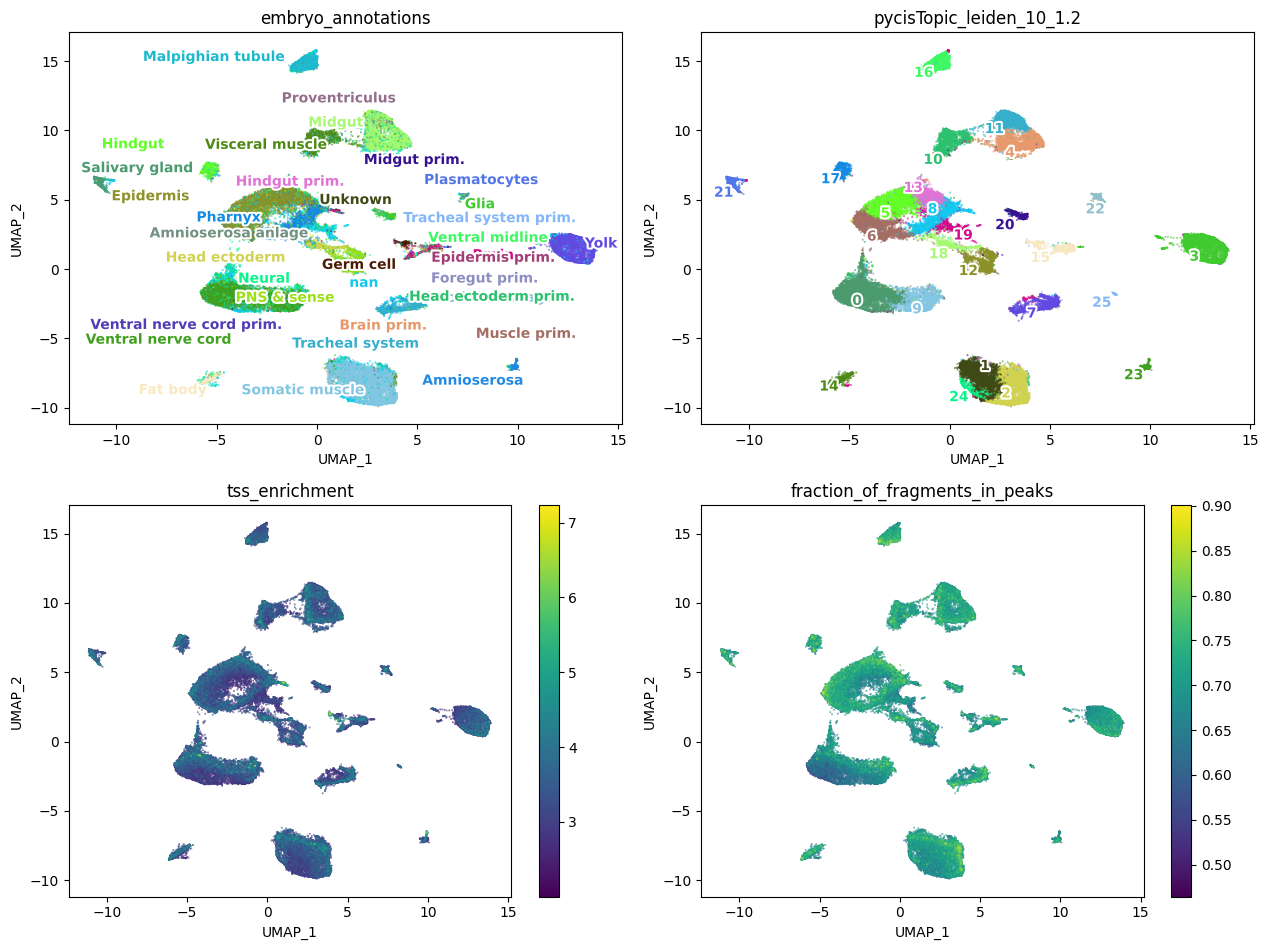

In [30]:
# model 180 topics

plot_metadata(
    cistopic_obj,
    reduction_name='UMAP',
    variables=['embryo_annotations', 'pycisTopic_leiden_10_1.2', 'tss_enrichment', 'fraction_of_fragments_in_peaks'],
    target='cell', num_columns=2,
    remove_nan = False,
    text_size=10,
    dot_size=0.1)

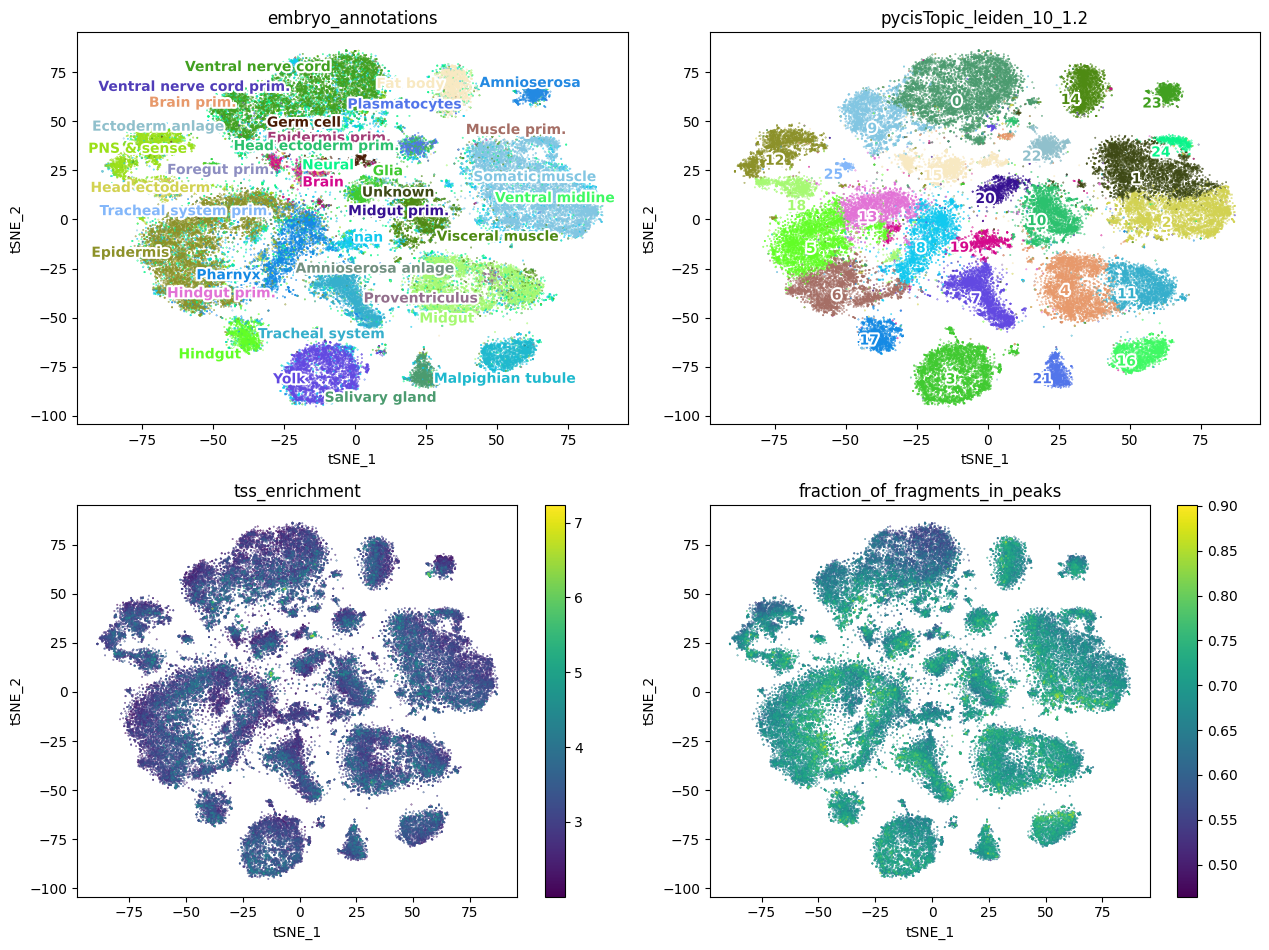

In [32]:
# model 180 topics

plot_metadata(
    cistopic_obj,
    reduction_name='tSNE',
    variables=['embryo_annotations', 'pycisTopic_leiden_10_1.2', 'tss_enrichment', 'fraction_of_fragments_in_peaks'],
    target='cell', num_columns=2,
    remove_nan = False,
    text_size=10,
    dot_size=0.1)

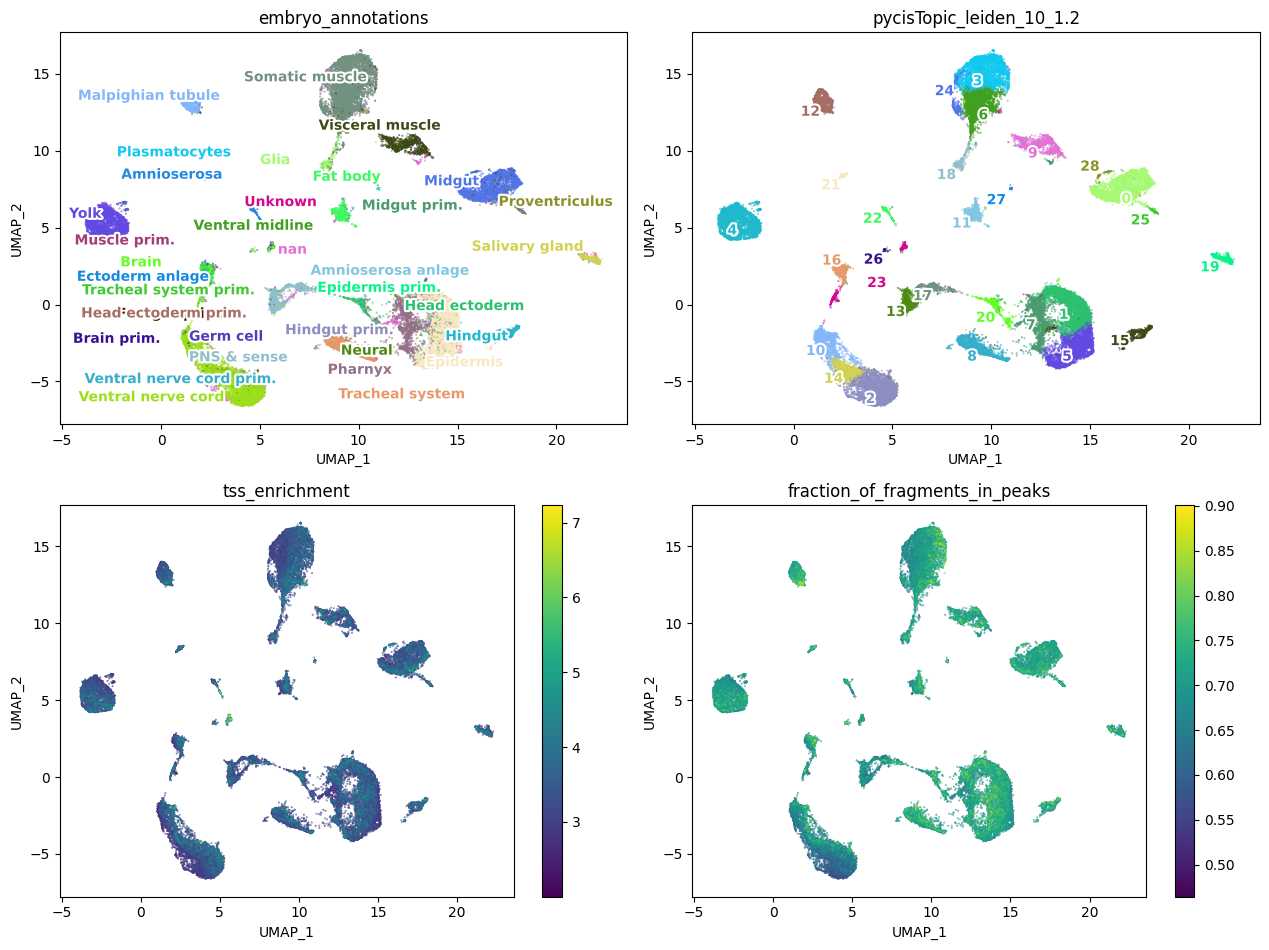

In [46]:
# model 320
plot_metadata(
    cistopic_obj,
    reduction_name='UMAP',
    variables=['embryo_annotations', 'pycisTopic_leiden_10_1.2', 'tss_enrichment', 'fraction_of_fragments_in_peaks'],
    target='cell', num_columns=2,
    remove_nan = False,
    text_size=10,
    dot_size=0.1)

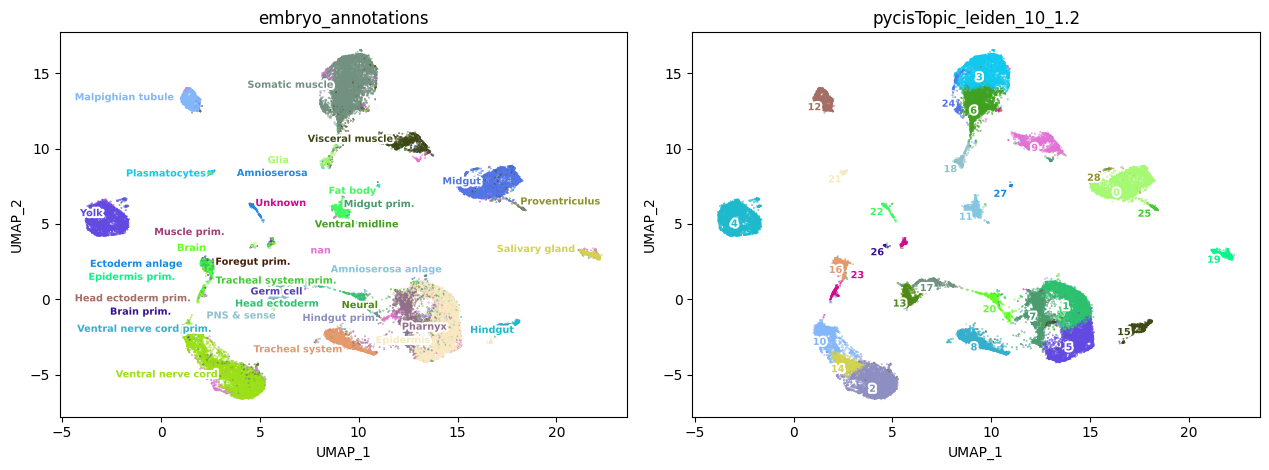

In [50]:
# model 320
plot_metadata(
    cistopic_obj,
    reduction_name='UMAP',
    variables=['embryo_annotations', 'pycisTopic_leiden_10_1.2'],
    target='cell', num_columns=2,
    remove_nan = False,
    show_label = True,
    show_legend = False, 
    text_size=7,
    dot_size=0.1)

## lay over annotations to all cells

In [34]:
clustering_resolution = 'pycisTopic_leiden_10_1.2'
annotation_key = 'embryo_annotations'

cluster_to_annot = {}
mapping_dict = {}
for name, df in cistopic_obj.cell_data.groupby(clustering_resolution):
    number_of_cells = len(df)
    value_counts = df[annotation_key].value_counts()
    print(name)
    print(number_of_cells)
    print(value_counts)

0
6431
Ventral nerve cord          4554
Neural                       845
PNS & sense                   79
Germ cell                     12
Glia                           9
Ventral midline                3
Visceral muscle                3
Somatic muscle                 3
Brain                          2
Ventral nerve cord prim.       2
Epidermis                      1
Unknown                        1
Pharnyx                        1
Tracheal system                1
Name: embryo_annotations, dtype: int64
1
4277
Somatic muscle        3586
Neural                 180
Visceral muscle         58
Fat body                17
Glia                    12
Ventral nerve cord       3
Muscle prim.             3
Brain                    3
Tracheal system          2
Epidermis                2
Germ cell                1
Salivary gland           1
Hindgut                  1
Unknown                  1
Name: embryo_annotations, dtype: int64
10
2668
Visceral muscle       2143
Neural                 125
Somati

In [35]:
embyro_annotations_paper = {'0': 'VNC', 
                '1': 'Somatic_muscle', 
                '2': 'Somatic_muscle', 
                '3': 'Yolk', 
                '4': 'Midgut', 
                '5': 'Epidermis', 
                '6': 'Epidermis', 
                '7': 'Tracheal_system', 
                '8': 'Pharnyx', 
                '9': 'VNC', 
                '10': 'Visceral_muscle', 
                '11': 'Midgut', 
                '12': 'PNS_sense', 
                '13': 'Epidermis', 
                '14': 'Fatbody', 
                '15': 'Brain', 
                '16': 'Malpighian_tubule', 
                '17': 'Hindgut', 
                '18': 'Head_ectoderm', 
                '19': 'NA', 
                '20': 'Glia', 
                '21': 'Salivary_gland', 
                '22': 'Plasmatocytes', 
                '23': 'Amnioserosa', 
                '24': 'Somatic_muscle', 
                '25': 'Glia'}

In [36]:
for number, new_value in embyro_annotations_paper.items():
    cistopic_obj.cell_data.loc[
        cistopic_obj.cell_data["pycisTopic_leiden_10_1.2"] == number, "embyro_annotations_paper"] = new_value

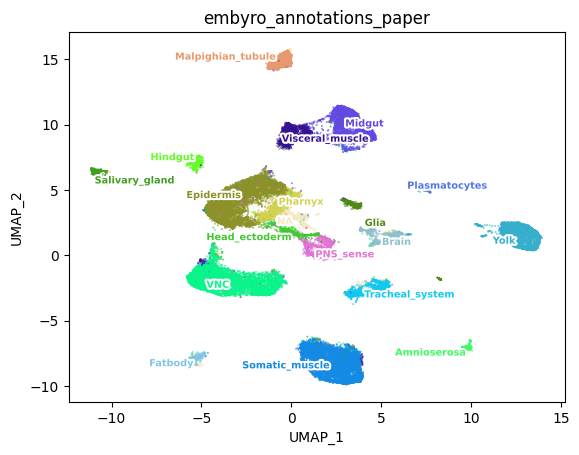

In [37]:
# model 180
plot_metadata(
    cistopic_obj,
    reduction_name='UMAP',
    variables=['embyro_annotations_paper'],
    target='cell', num_columns=1,
    remove_nan = False,
    show_label = True,
    show_legend = False, 
    text_size=7,
    dot_size=0.1)

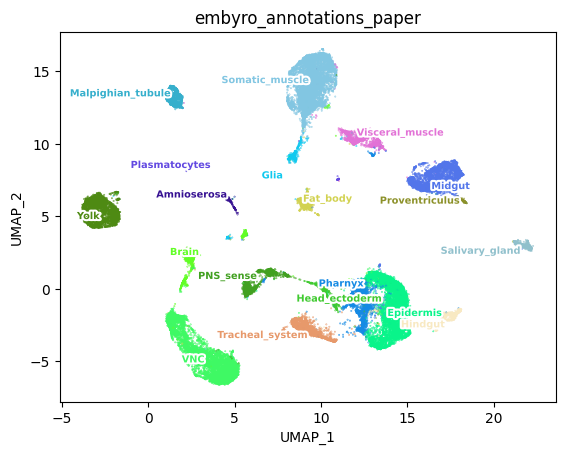

In [55]:
# model 320
plot_metadata(
    cistopic_obj,
    reduction_name='UMAP',
    variables=['embyro_annotations_paper'],
    target='cell', num_columns=1,
    remove_nan = False,
    show_label = True,
    show_legend = False, 
    text_size=7,
    dot_size=0.1)

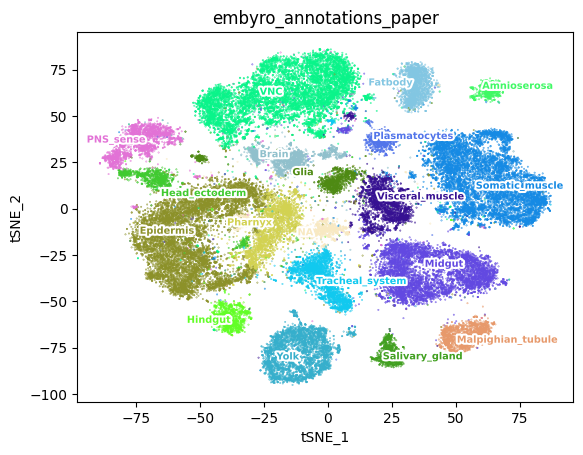

In [38]:
# model 180
plot_metadata(
    cistopic_obj,
    reduction_name='tSNE',
    variables=['embyro_annotations_paper'],
    target='cell', num_columns=1,
    remove_nan = False,
    show_label = True,
    show_legend = False, 
    text_size=7,
    dot_size=0.1)

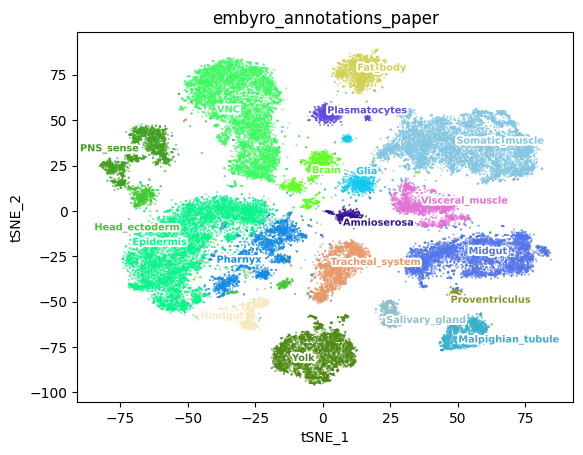

In [56]:
# model 320
plot_metadata(
    cistopic_obj,
    reduction_name='tSNE',
    variables=['embyro_annotations_paper'],
    target='cell', num_columns=1,
    remove_nan = False,
    show_label = True,
    show_legend = False, 
    text_size=7,
    dot_size=0.1)

# pseudobulk

In [40]:
import pandas as pd
import pyranges as pr
chromsizes = pd.read_csv('/staging/leuven/stg_00002/lcb/eceksi/resources/dm6_nochr.chrom.sizes', sep='\t', header=None)
chromsizes.columns=['Chromosome', 'End']
chromsizes['Start']=[0]*chromsizes.shape[0]
chromsizes=chromsizes.loc[:,['Chromosome', 'Start', 'End']]
# Exceptionally in this case, to agree with CellRangerARC annotations
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].replace('v', '.') for x in range(len(chromsizes['Chromosome']))]
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].split('_')[1] if len(chromsizes['Chromosome'][x].split('_')) > 1 else chromsizes['Chromosome'][x] for x in range(len(chromsizes['Chromosome']))]
chromsizes=pr.PyRanges(chromsizes)

tmp_dir = '/scratch/leuven/350/vsc35050/'

In [45]:
from pycisTopic.pseudobulk_peak_calling import *
bw_paths, bed_paths = export_pseudobulk(input_data = cistopic_obj.cell_data,
                 variable = 'embyro_annotations_paper',
                 sample_id_col = 'sample_id',
                 chromsizes = chromsizes,
                 bed_path = out_dir + 'pseudobulk/embyro_annotations_paper/pseudobulk_bed_files/',
                 bigwig_path = out_dir + 'pseudobulk/embyro_annotations_paper/pseudobulk_bw_files/',
                 path_to_fragments = fragments_dict,
                 n_cpu = 10,
                 normalize_bigwig = True,
                 #remove_duplicates = True,
                 temp_dir = tmp_dir + 'ray_spill',
                 split_pattern = '___')

2024-08-14 09:27:05,635 cisTopic     INFO     Splitting fragments by cell type.


/opt/venv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


2024-08-14 09:36:13,122 cisTopic     INFO     generating bigwig files


In [46]:
with open(out_dir + 'pseudobulk/embyro_annotations_paper/pseudobulk_bed_files/bed_paths.pkl', 'wb') as f:
  pickle.dump(bed_paths, f)
with open(out_dir + 'pseudobulk/embyro_annotations_paper/pseudobulk_bw_files/bw_paths.pkl', 'wb') as f:
  pickle.dump(bw_paths, f)

In [44]:
fragments_dict = {
     'exp1_hrs16-20_b1': '/staging/leuven/stg_00002/lcb/hdickm/projects/embryo_data/fragments/exp1_hrs16-20_b1.fragments_nochr.tsv.bgz',
     'exp2_hrs16-20_b1': '/staging/leuven/stg_00002/lcb/hdickm/projects/embryo_data/fragments/exp2_hrs16-20_b1.fragments_nochr.tsv.bgz'}

# DARs

In [48]:
from pycisTopic.diff_features import *
imputed_acc_obj = impute_accessibility(cistopic_obj, selected_cells=None, selected_regions=None, scale_factor=10**6)

normalized_imputed_acc_obj = normalize_scores(imputed_acc_obj, scale_factor=10**4)


2024-08-14 09:40:01,833 cisTopic     INFO     Imputing region accessibility
2024-08-14 09:40:01,834 cisTopic     INFO     Impute region accessibility for regions 0-20000
2024-08-14 09:40:07,994 cisTopic     INFO     Impute region accessibility for regions 20000-40000
2024-08-14 09:40:14,441 cisTopic     INFO     Impute region accessibility for regions 40000-60000
2024-08-14 09:40:20,540 cisTopic     INFO     Impute region accessibility for regions 60000-80000
2024-08-14 09:40:22,741 cisTopic     INFO     Done!
2024-08-14 09:40:22,744 cisTopic     INFO     Normalizing imputed data
2024-08-14 09:40:41,740 cisTopic     INFO     Done!


2024-08-14 09:40:41,749 cisTopic     INFO     Calculating mean
2024-08-14 09:40:45,586 cisTopic     INFO     Calculating variance


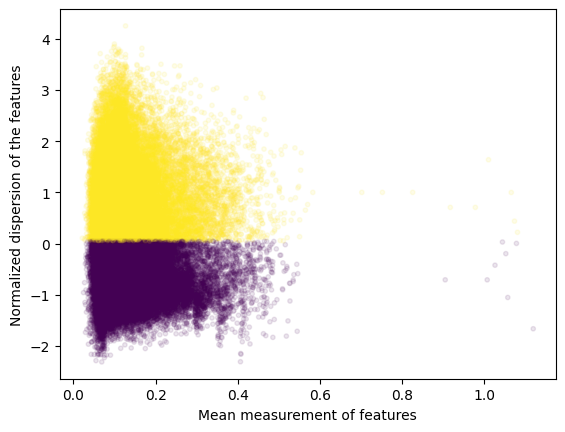

2024-08-14 09:41:09,606 cisTopic     INFO     Done!


In [49]:
variable_regions = find_highly_variable_features(normalized_imputed_acc_obj,
                                           min_disp = 0.05,
                                           min_mean = 0.0125,
                                           max_mean = 3,
                                           max_disp = np.inf,
                                           n_bins=20,
                                           n_top_features=None,
                                           plot=True,
                                           #save= outDir + '10x_ATAC_16_20hAEL/DARs/HVR_plot.pdf'
                                                )

In [50]:
markers_dict= find_diff_features(cistopic_obj,
                      imputed_acc_obj,
                      variable='embyro_annotations_paper',
                      var_features=variable_regions,
                      contrasts=None,
                      adjpval_thr=0.05,
                      log2fc_thr=np.log2(1.5),
                      n_cpu=70)


2024-08-14 09:41:17,840	INFO worker.py:1724 -- Started a local Ray instance.


2024-08-14 09:41:20,070 cisTopic     INFO     Subsetting data for Amnioserosa (810 of 61480)
2024-08-14 09:41:25,059 cisTopic     INFO     Computing p-value for Amnioserosa
2024-08-14 09:41:37,799 cisTopic     INFO     Computing log2FC for Amnioserosa
2024-08-14 09:41:39,804 cisTopic     INFO     Amnioserosa done!
2024-08-14 09:41:39,829 cisTopic     INFO     Subsetting data for Brain (1861 of 61480)
2024-08-14 09:41:40,112 cisTopic     INFO     Computing p-value for Brain
2024-08-14 09:41:50,213 cisTopic     INFO     Computing log2FC for Brain
2024-08-14 09:41:50,332 cisTopic     INFO     Brain done!
2024-08-14 09:41:50,373 cisTopic     INFO     Subsetting data for Epidermis (9394 of 61480)
2024-08-14 09:41:50,647 cisTopic     INFO     Computing p-value for Epidermis
2024-08-14 09:42:00,941 cisTopic     INFO     Computing log2FC for Epidermis
2024-08-14 09:42:01,064 cisTopic     INFO     Epidermis done!
2024-08-14 09:42:01,106 cisTopic     INFO     Subsetting data for Fatbody (1910 of

In [51]:
with open(out_dir + 'DARs/DARs_embyro_annotations_paper_sciATAC_14082024.pkl', 'wb') as f:
  pickle.dump(markers_dict, f)

In [52]:
with open(out_dir + 'DARs/Imputed_accessibility.pkl', 'wb') as f:
  pickle.dump(imputed_acc_obj, f)

with open(out_dir + 'DARs/variable_regions.pkl', 'wb') as f:
  pickle.dump(variable_regions, f)

In [7]:
# make markers dict for annotations
import gzip
import pickle

# Define the path to the gzipped pickle file
gzip_pickle_path = out_dir + 'DARs/DARs_embyro_annotations_paper_sciATAC_14082024.pkl.gz'

# Open and load the gzipped pickle file
with gzip.open(gzip_pickle_path, 'rb') as infile:
    markers_dict = pickle.load(infile)

In [8]:
print("Number of DARs found:")
print("---------------------")
for x in markers_dict:
    print(f"  {x}: {len(markers_dict[x])}")

Number of DARs found:
---------------------
  Amnioserosa: 2709
  Brain: 1973
  Epidermis: 6137
  Fatbody: 2307
  Glia: 955
  Head_ectoderm: 2489
  Hindgut: 3442
  Malpighian_tubule: 2812
  Midgut: 3466
  NA: 1472
  PNS_sense: 4556
  Pharnyx: 3959
  Plasmatocytes: 2070
  Salivary_gland: 2406
  Somatic_muscle: 4337
  Tracheal_system: 4197
  VNC: 7323
  Visceral_muscle: 2924
  Yolk: 4636


In [9]:
out_dir

'/lustre1/project/stg_00002/lcb/hydrop_v2_paper/fly/sci_ATAC/'

In [21]:
# save as pycistarget list
def create_pyranges_with_name(markers_dict):
    """
    Create a dictionary of PyRanges objects with an additional 'Name' column.
    The 'Name' column will be a string in the format 'Chromosome:Start-End'.

    Parameters:
        markers_dict (dict): A dictionary where keys are categories (e.g., cell types)
                             and values are DataFrames with region indices.

    Returns:
        dict: A dictionary of PyRanges objects with an additional 'Name' column.
    """
    import pandas as pd
    import pyranges as pr

    pyranges_dict = {}
    for key, df in markers_dict.items():
        # Extract chromosome, start, and end from index
        chromosome_starts_ends = [region.split(':') for region in df.index]
        chromosome_starts_ends = [
            (
                region[0],  # Chromosome
                int(region[1].split('-')[0]),  # Start
                int(region[1].split('-')[1])  # End
            )
            for region in chromosome_starts_ends
        ]
        
        # Convert to DataFrame with proper column names
        bed_df = pd.DataFrame(chromosome_starts_ends, columns=['Chromosome', 'Start', 'End'])
        
        # Add a 'Name' column in the format 'Chromosome:Start-End'
        bed_df['Name'] = bed_df.apply(
            lambda row: f"{row['Chromosome']}:{row['Start']}-{row['End']}", axis=1
        )
        
        # Create PyRanges object
        pyranges_dict[key] = pr.PyRanges(bed_df)

    return pyranges_dict

pyranges_dict = create_pyranges_with_name(markers_dict)

with open(out_dir + 'DARs/pyranges_dict_of_DARs_sciATAC_embryo_cleanedup_nozeros.pkl', 'wb') as f:
  pickle.dump(pyranges_dict, f)


In [22]:
pyranges_dict

{'Amnioserosa': +--------------+-----------+-----------+----------------------+
 | Chromosome   | Start     | End       | Name                 |
 | (category)   | (int32)   | (int32)   | (object)             |
 |--------------+-----------+-----------+----------------------|
 | 2L           | 4789255   | 4789755   | 2L:4789255-4789755   |
 | 2L           | 3013381   | 3013881   | 2L:3013381-3013881   |
 | 2L           | 17216835  | 17217335  | 2L:17216835-17217335 |
 | 2L           | 18890421  | 18890921  | 2L:18890421-18890921 |
 | ...          | ...       | ...       | ...                  |
 | X            | 5352657   | 5353157   | X:5352657-5353157    |
 | X            | 9254315   | 9254815   | X:9254315-9254815    |
 | X            | 6339683   | 6340183   | X:6339683-6340183    |
 | X            | 12668976  | 12669476  | X:12668976-12669476  |
 +--------------+-----------+-----------+----------------------+
 Unstranded PyRanges object has 2,709 rows and 4 columns from 6 chromosomes

In [15]:
#the example one
bed_dict_one = {"Epithelial":pr.readers.read_bed("/lustre1/project/stg_00002/lcb/eceksi/shares/one_per_broad/log2fcth_1_pvalth_1_topn_1000/Topic_1.bed"),
                "Fat_cell":pr.readers.read_bed("/lustre1/project/stg_00002/lcb/eceksi/shares/one_per_broad/log2fcth_1_pvalth_1_topn_1000/Topic_2.bed"),
                "Gland":pr.readers.read_bed("/lustre1/project/stg_00002/lcb/eceksi/shares/one_per_broad/log2fcth_1_pvalth_1_topn_1000/Topic_3.bed"),
                "Glia":pr.readers.read_bed("/lustre1/project/stg_00002/lcb/eceksi/shares/one_per_broad/log2fcth_1_pvalth_1_topn_1000/Topic_4.bed"),
                "Hemocytes":pr.readers.read_bed("/lustre1/project/stg_00002/lcb/eceksi/shares/one_per_broad/log2fcth_1_pvalth_1_topn_1000/Topic_5.bed"),
                "Muscles":pr.readers.read_bed("/lustre1/project/stg_00002/lcb/eceksi/shares/one_per_broad/log2fcth_1_pvalth_1_topn_1000/Topic_6.bed"),
                "Neuronal":pr.readers.read_bed("/lustre1/project/stg_00002/lcb/eceksi/shares/one_per_broad/log2fcth_1_pvalth_1_topn_1000/Topic_7.bed"),
                "Oenocyte":pr.readers.read_bed("/lustre1/project/stg_00002/lcb/eceksi/shares/one_per_broad/log2fcth_1_pvalth_1_topn_1000/Topic_8.bed"),
                "Sensory":pr.readers.read_bed("/lustre1/project/stg_00002/lcb/eceksi/shares/one_per_broad/log2fcth_1_pvalth_1_topn_1000/Topic_9.bed"),
                "Somatic_precursor":pr.readers.read_bed("/lustre1/project/stg_00002/lcb/eceksi/shares/one_per_broad/log2fcth_1_pvalth_1_topn_1000/Topic_10.bed"),
                "Trachea":pr.readers.read_bed("/lustre1/project/stg_00002/lcb/eceksi/shares/one_per_broad/log2fcth_1_pvalth_1_topn_1000/Topic_11.bed")
               }

In [16]:
bed_dict_one

{'Epithelial': +--------------+-----------+-----------+----------------------+
 | Chromosome   | Start     | End       | Name                 |
 | (category)   | (int32)   | (int32)   | (object)             |
 |--------------+-----------+-----------+----------------------|
 | 2L           | 5476755   | 5477255   | 2L:5476755-5477255   |
 | 2L           | 4286636   | 4287136   | 2L:4286636-4287136   |
 | 2L           | 5475960   | 5476460   | 2L:5475960-5476460   |
 | 2L           | 17725588  | 17726088  | 2L:17725588-17726088 |
 | ...          | ...       | ...       | ...                  |
 | Y            | 1426227   | 1426727   | Y:1426227-1426727    |
 | Y            | 1421945   | 1422445   | Y:1421945-1422445    |
 | Y            | 1449555   | 1450055   | Y:1449555-1450055    |
 | Y            | 1435317   | 1435817   | Y:1435317-1435817    |
 +--------------+-----------+-----------+----------------------+
 Unstranded PyRanges object has 1,000 rows and 4 columns from 7 chromosomes.

In [54]:
out_dir_3 = out_dir + 'DARs/bed_embyro_annotations_paper_sciATAC_chr_top1000/'

In [59]:
from pycisTopic.utils import region_names_to_coordinates
import os

for cell_type in markers_dict:
    # Select the top 1000 regions based on Log2FC score
    top_regions = markers_dict[cell_type].nlargest(1000, 'Log2FC')
    
    # Convert region names to coordinates and sort them
    bed_df = region_names_to_coordinates(top_regions.index).sort_values(
        ["Chromosome", "Start", "End"]
    )
    
    # Add "chr" prefix to the Chromosome column
    bed_df['Chromosome'] = 'chr' + bed_df['Chromosome'].astype(str)
    
    # Write the sorted coordinates to a BED file
    bed_df.to_csv(
        os.path.join(out_dir_3, f"{cell_type}.bed"),
        sep="\t",
        header=False,
        index=False
    )

In [60]:
out_dir_4 = out_dir + 'DARs/bed_embyro_annotations_paper_sciATAC_nochr_top1000/'

In [61]:
from pycisTopic.utils import region_names_to_coordinates
for cell_type in markers_dict:
    # Select the top 1000 regions based on log score
    top_regions = markers_dict[cell_type].nlargest(1000, 'Log2FC')
    
    # Convert region names to coordinates and sort them
    bed_df = region_names_to_coordinates(top_regions.index).sort_values(
        ["Chromosome", "Start", "End"]
    )
    
    # Write the sorted coordinates to a BED file
    bed_df.to_csv(
        os.path.join(out_dir_4, f"{cell_type}.bed"),
        sep="\t",
        header=False,
        index=False
    )

In [58]:
pwd

'/lustre1/project/stg_00002/lcb/hydrop_v2_paper/fly/sci_ATAC'

In [13]:
from pycisTopic.utils import region_names_to_coordinates
import os

# Define output directory
out_dir_3 = os.path.join(out_dir, 'DARs/bed_embyro_annotations_paper_sciATAC_nochr_all_bed')

# Ensure the output directory exists
os.makedirs(out_dir_3, exist_ok=True)

# Iterate through each cell type in the markers dictionary
for cell_type in markers_dict:
    all_regions = markers_dict[cell_type]
    
    print(f"Total regions in {cell_type}: {len(all_regions)}")
    
    # Convert region names to coordinates and sort them
    bed_df = region_names_to_coordinates(all_regions.index).sort_values(
        ["Chromosome", "Start", "End"]
    )
    print(f"Converted regions for {cell_type}: {len(bed_df)}")
    
    # Write all coordinates to a BED file
    bed_file_path = os.path.join(out_dir_3, f"{cell_type}.bed")
    bed_df.to_csv(
        bed_file_path,
        sep="\t",
        header=False,
        index=False
    )
    print(f"Saved {len(all_regions)} regions for {cell_type} to {bed_file_path}")


Total regions in Amnioserosa: 2709
Converted regions for Amnioserosa: 2709
Saved 2709 regions for Amnioserosa to /lustre1/project/stg_00002/lcb/hydrop_v2_paper/fly/sci_ATAC/DARs/bed_embyro_annotations_paper_sciATAC_nochr_all_bed/Amnioserosa.bed
Total regions in Brain: 1973
Converted regions for Brain: 1973
Saved 1973 regions for Brain to /lustre1/project/stg_00002/lcb/hydrop_v2_paper/fly/sci_ATAC/DARs/bed_embyro_annotations_paper_sciATAC_nochr_all_bed/Brain.bed
Total regions in Epidermis: 6137
Converted regions for Epidermis: 6137
Saved 6137 regions for Epidermis to /lustre1/project/stg_00002/lcb/hydrop_v2_paper/fly/sci_ATAC/DARs/bed_embyro_annotations_paper_sciATAC_nochr_all_bed/Epidermis.bed
Total regions in Fatbody: 2307
Converted regions for Fatbody: 2307
Saved 2307 regions for Fatbody to /lustre1/project/stg_00002/lcb/hydrop_v2_paper/fly/sci_ATAC/DARs/bed_embyro_annotations_paper_sciATAC_nochr_all_bed/Fatbody.bed
Total regions in Glia: 955
Converted regions for Glia: 955
Saved 955

# run pycistarget on NA to see what it could be

might be heart (hb) but could also be head development or something related to brain - might also just be rest clusters

has the highest duplication count (Tss is normal to low = would make sense to take this out)

not really needed to take out as I can also just use the pseudobulk tracks/DARs of the other clusters as they are made based on the recent annotations having NA as separate cluster

Looking at **pseudobulk** show that the tracks are still very noisy but high (just as before)

In [62]:
print(cistopic_obj.cell_data.columns)

Index(['cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc',
       'cisTopic_log_nr_acc', 'sample_id', 'barcode_rank',
       'total_fragments_count', 'log10_total_fragments_count',
       'unique_fragments_count', 'log10_unique_fragments_count',
       'total_fragments_in_peaks_count',
       'log10_total_fragments_in_peaks_count',
       'unique_fragments_in_peaks_count',
       'log10_unique_fragments_in_peaks_count',
       'fraction_of_fragments_in_peaks', 'duplication_count',
       'duplication_ratio', 'tss_enrichment', 'pdf_values_for_tss_enrichment',
       'pdf_values_for_fraction_of_fragments_in_peaks',
       'pdf_values_for_duplication_ratio', 'barcode',
       'Doublet_scores_fragments', 'Predicted_doublets_fragments',
       'pycisTopic_leiden_10_1.2', 'embryo_annotations',
       'embyro_annotations_paper'],
      dtype='object')


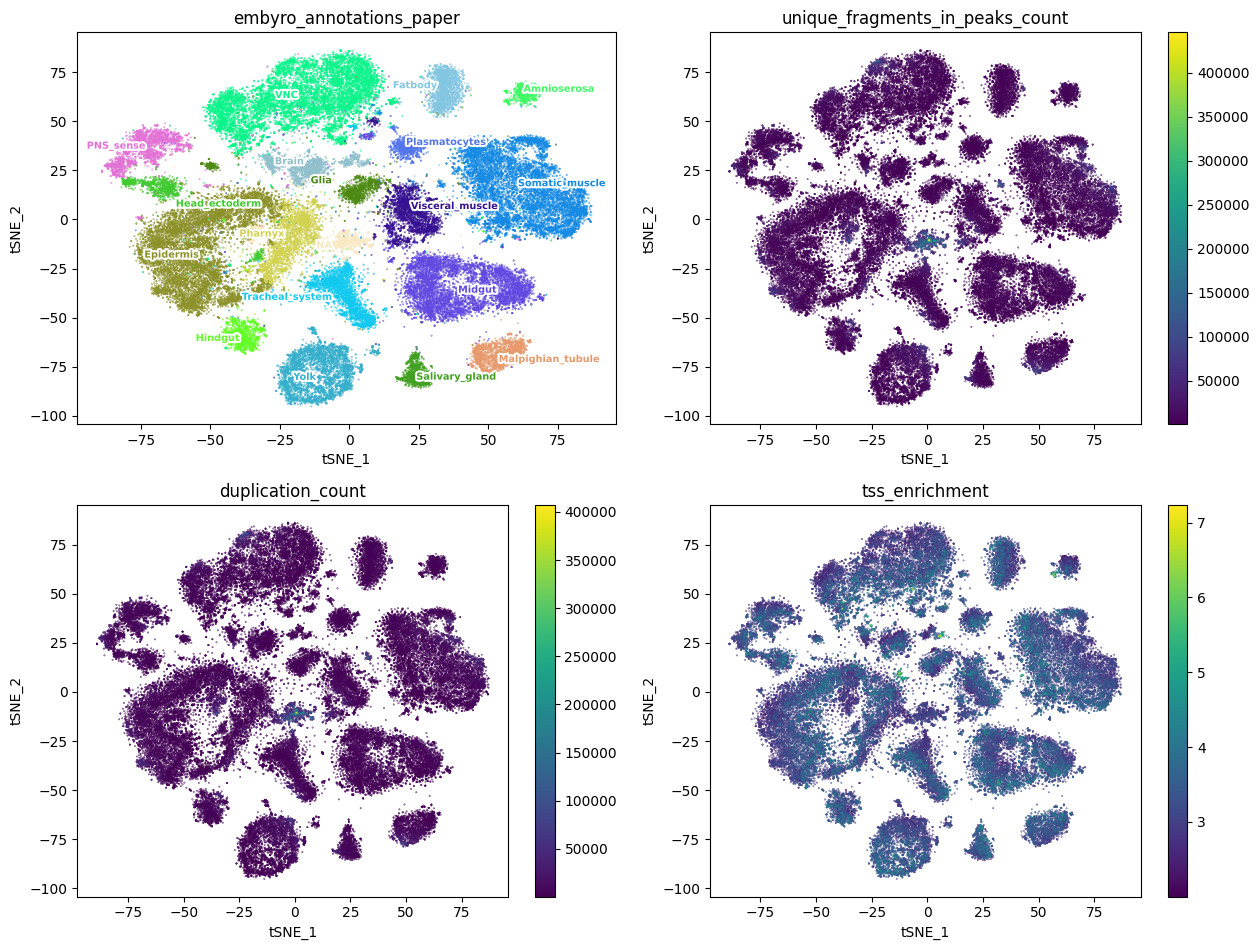

In [65]:
# model 180
plot_metadata(
    cistopic_obj,
    reduction_name='tSNE',
    variables=['embyro_annotations_paper', 'unique_fragments_in_peaks_count', 'duplication_count', 'tss_enrichment'],
    target='cell', num_columns=2,
    remove_nan = False,
    show_label = True,
    show_legend = False, 
    text_size=7,
    dot_size=0.1)

# pycistarget on everything to compare with 10x and HyDrop

In [ ]:
# on sciATAC all
#!/bin/bash

# Define the directory containing the topic .bed files
BED_DIR="/lustre1/project/stg_00002/lcb/hydrop_v2_paper/fly/sci_ATAC/DARs/bed_embyro_annotations_paper_sciATAC_chr_top1000/"

# Define the output directory for pycistarget
OUTPUT_DIR="/lustre1/project/stg_00002/lcb/hydrop_v2_paper/fly/sci_ATAC/pycistarget/"

# Loop through each Topic*chr.bed file in the BED_DIR directory
for BED_FILE in ${BED_DIR}/*.bed; do
  # Extract the base name of the file without the extension (e.g., "Mesectoderm")
  BASE_NAME=$(basename ${BED_FILE} .bed)

  # Construct the name parameter using the base name
  NAME="${BASE_NAME}"

  # Run the pycistarget command with the current bed file and dynamically constructed name
  singularity exec -B /lustre1,/staging,/data,/vsc-hard-mounts,/scratch /data/leuven/software/biomed/singularity_images/images_Seppe/pycistopic_2.0a.sif pycistarget cistarget \
    --cistarget_db_fname /staging/leuven/stg_00002/lcb/icistarget/data/make_rankings/v10_clust/CTX_dm6/CTX_dm6_FCA_atac_regions_no_bg_with_mask/CTX_dm6_FCA_atac_regions_no_bg_with_mask.regions_vs_motifs.rankings.v2.feather \
    --bed_fname ${BED_FILE} \
    --output_folder ${OUTPUT_DIR} \
    --path_to_motif_annotation /user/leuven/350/vsc35050/hdickm/resources/motifs-v10nr_clust-nr.flybase-m0.001-o0.0.tbl \
    --species dm6 \
    --name ${NAME} \
    --write_html \
    --output_mode tsv
done

# pseudobulk downsampled

In [4]:
import gzip
import pickle

# Define the path to the gzipped pickle file
gzip_pickle_path = '/lustre1/project/stg_00002/lcb/hydrop_v2_paper/fly/sci_ATAC/cistopic_objs/cistopic_obj_sciATAC_16_20hAEL_16072024_180topics.pkl.gz'

# Open and load the gzipped pickle file
with gzip.open(gzip_pickle_path, 'rb') as infile:
    cistopic_obj_sciATAC = pickle.load(infile)

2024-12-19 10:43:38,405	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [6]:
cistopic_obj_sciATAC.path_to_fragments

{'exp1_hrs16-20_b1': '/staging/leuven/stg_00002/lcb/hdickm/projects/embryo_data/fragments/exp1_hrs16-20_b1.fragments_nochr.tsv.gz',
 'exp2_hrs16-20_b1': '/staging/leuven/stg_00002/lcb/hdickm/projects/embryo_data/fragments/exp2_hrs16-20_b1.fragments_nochr.tsv.gz'}

In [7]:
cistopic_obj_sciATAC.cell_data.columns

Index(['cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc',
       'cisTopic_log_nr_acc', 'sample_id', 'barcode_rank',
       'total_fragments_count', 'log10_total_fragments_count',
       'unique_fragments_count', 'log10_unique_fragments_count',
       'total_fragments_in_peaks_count',
       'log10_total_fragments_in_peaks_count',
       'unique_fragments_in_peaks_count',
       'log10_unique_fragments_in_peaks_count',
       'fraction_of_fragments_in_peaks', 'duplication_count',
       'duplication_ratio', 'tss_enrichment', 'pdf_values_for_tss_enrichment',
       'pdf_values_for_fraction_of_fragments_in_peaks',
       'pdf_values_for_duplication_ratio', 'barcode',
       'Doublet_scores_fragments', 'Predicted_doublets_fragments',
       'pycisTopic_leiden_10_1.2', 'embryo_annotations',
       'embyro_annotations_paper'],
      dtype='object')

In [9]:
sample_counts = cistopic_obj_sciATAC.cell_data['embyro_annotations_paper'].value_counts().to_dict()
print(sample_counts)

{'Epidermis': 9394, 'VNC': 9124, 'Somatic_muscle': 8916, 'Midgut': 6355, 'Yolk': 4028, 'Tracheal_system': 2791, 'Pharnyx': 2729, 'Visceral_muscle': 2668, 'PNS_sense': 2347, 'Fatbody': 1910, 'Brain': 1861, 'Malpighian_tubule': 1759, 'Hindgut': 1285, 'Glia': 1247, 'Head_ectoderm': 1153, 'NA': 1060, 'Salivary_gland': 1041, 'Plasmatocytes': 1002, 'Amnioserosa': 810}


In [10]:
print(cistopic_obj_sciATAC)

CistopicObject from project cisTopic_merge with n_cells × n_regions = 61480 × 67162
